# 📱 TuniTech Advisor - ML Pipeline
## Week 2: Preprocessing → Feature Engineering → Feature Selection → Model Training → MLflow

**Authors:** Iheb Lamin & Malek Smida  
**Dataset:** 1,096 smartphones from Tunisian e-commerce sites

---
### 🔧 Approach: sklearn Pipeline & ColumnTransformer
We use a structured pipeline approach:
- **ColumnTransformer**: Apply different transformations to different column types
- **Pipeline**: Chain multiple preprocessing steps together
- **Benefits**: Reproducible, prevents data leakage, easy to deploy

---
# 🔧 Step 1: Preprocessing with Pipelines

### Architecture:
```
                    ┌─────────────────────────────────────┐
                    │        ColumnTransformer            │
                    │                                     │
Raw Data ──────────►│  ┌─────────────────────────────┐   │
                    │  │  Numerical Pipeline          │   │
                    │  │  ├── KNNImputer (k=5)        │   │
                    │  │  └── StandardScaler          │   │──────► Transformed
                    │  └─────────────────────────────┘   │         Features
                    │                                     │
                    │  ┌─────────────────────────────┐   │
                    │  │  Categorical Pipeline        │   │
                    │  │  ├── SimpleImputer (mode)    │   │
                    │  │  └── OneHotEncoder/OrdinalEnc│   │
                    │  └─────────────────────────────┘   │
                    └─────────────────────────────────────┘
```

## 1.1 Import Libraries

In [123]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn: Pipeline & Transformers
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler,
    OneHotEncoder, 
    OrdinalEncoder,
    LabelEncoder
)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 1.2 Load Data

In [124]:
# Load dataset
df = pd.read_csv('../dataset/unified_smartphones_filled.csv')

print(f"📊 Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print()
print("Columns overview:")
for col in df.columns:
    dtype = df[col].dtype
    missing = df[col].isna().sum()
    unique = df[col].nunique()
    print(f"  • {col}: {dtype} | {unique} unique | {'⚠️ ' + str(missing) + ' missing' if missing > 0 else '✓'}")

📊 Dataset loaded: 1096 rows × 14 columns

Columns overview:
  • name: str | 1096 unique | ✓
  • brand: str | 27 unique | ✓
  • ram_gb: float64 | 12 unique | ✓
  • storage_gb: float64 | 13 unique | ✓
  • battery_mah: float64 | 31 unique | ✓
  • screen_inches: float64 | 28 unique | ✓
  • camera_rear_mp: float64 | 12 unique | ✓
  • camera_front_mp: float64 | 12 unique | ✓
  • network: str | 3 unique | ✓
  • os: str | 7 unique | ✓
  • processor_type: str | 9 unique | ✓
  • price: float64 | 124 unique | ⚠️ 143 missing
  • url: str | 1096 unique | ✓
  • source: str | 4 unique | ✓


In [125]:
# Quick preview
df.head()

,name,brand,ram_gb,storage_gb,battery_mah,screen_inches,camera_rear_mp,camera_front_mp,network,os,processor_type,price,url,source
0,Smartphone Lesia Young 1 | 2Go / 16Go | Vert,Lesia,4.0,16.0,2500.0,5.0,5.0,2.0,4G,Android 13,Quad Core,159.0,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
1,Smartphone Lesia Young 1 | 2Go / 16Go | Bleu,Lesia,4.0,16.0,2500.0,5.0,5.0,2.0,4G,Android 13,Quad Core,159.0,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
2,Smartphone Lesia Young 6 4Go /16Go - Noir,Lesia,4.0,16.0,3000.0,6.0,5.0,2.0,3G,Android 13,Octa Core,179.0,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
3,Smartphone Lesia Young 6 4Go /16Go - Silver,Lesia,4.0,16.0,3000.0,6.0,5.0,2.0,3G,Android 13,Octa Core,179.0,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
4,Smartphone Lesia Young 6 4Go /16Go - Gold,Lesia,4.0,16.0,3000.0,6.0,5.0,2.0,3G,Android 13,Octa Core,179.0,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet


## 1.3 Handle Missing Prices & Define Feature Groups

**Decision:** Drop rows without price (can't recommend without knowing cost)

In [126]:
# Drop rows without price
print(f"Before: {len(df)} rows")
df = df.dropna(subset=['price']).copy()
print(f"After:  {len(df)} rows (dropped {1096 - len(df)} without price)")

Before: 1096 rows
After:  953 rows (dropped 143 without price)


In [127]:
# Define column groups
# ═══════════════════════════════════════════════════════════════════

# Numerical features - will be scaled
NUMERICAL_FEATURES = [
    'ram_gb',           # RAM in GB (2-512)
    'storage_gb',       # Storage in GB (1-512)
    'battery_mah',      # Battery capacity (2500-8300)
    'screen_inches',    # Screen size (5.0-6.9)
    'camera_rear_mp',   # Rear camera megapixels (5-200)
    'camera_front_mp',  # Front camera megapixels (2-50)
]

# Categorical features - will be encoded
CATEGORICAL_FEATURES = [
    'brand',            # Phone brand (Samsung, Apple, etc.) - 27 unique
    'network',          # Network type (3G, 4G, 5G) - 3 unique, ordinal
    'os',               # Operating system (Android, iOS) - 7 unique
    'processor_type',   # Processor (Octa Core, etc.) - 9 unique
]

# Target/Reference columns - not for feature transformation
TARGET = 'price'  # Will use for price-based recommendations
IDENTIFIERS = ['name', 'url', 'source']  # Keep for reference

print("📊 Feature Groups Defined:")
print(f"  Numerical ({len(NUMERICAL_FEATURES)}): {NUMERICAL_FEATURES}")
print(f"  Categorical ({len(CATEGORICAL_FEATURES)}): {CATEGORICAL_FEATURES}")
print(f"  Target: {TARGET}")
print(f"  Identifiers: {IDENTIFIERS}")

📊 Feature Groups Defined:
  Numerical (6): ['ram_gb', 'storage_gb', 'battery_mah', 'screen_inches', 'camera_rear_mp', 'camera_front_mp']
  Categorical (4): ['brand', 'network', 'os', 'processor_type']
  Target: price
  Identifiers: ['name', 'url', 'source']


## 1.4 Build Preprocessing Pipelines

### Pipeline Structure:
1. **Numerical Pipeline:**
   - `KNNImputer(n_neighbors=5)` → Fill missing using K-nearest neighbors (smarter!)
   - `StandardScaler()` → Normalize to mean=0, std=1

2. **Categorical Pipeline:**
   - `SimpleImputer(strategy='most_frequent')` → Fill missing with mode
   - `OneHotEncoder()` → Create binary columns for each category

3. **ColumnTransformer:** Combines both pipelines

### Why KNNImputer for numerical features?
- Uses **similar phones** to estimate missing values
- If a phone has 8GB RAM & 256GB storage, it likely has ~5000mAh battery
- Considers **feature correlations** (premium specs are correlated)
- Better than median which ignores relationships between features

In [128]:
# ═══════════════════════════════════════════════════════════════════
# NUMERICAL PIPELINE
# ═══════════════════════════════════════════════════════════════════
# Step 1: Impute missing values using KNN (uses similar phones)
#         - n_neighbors=5: Look at 5 most similar phones
#         - Smarter than median: considers feature relationships
# Step 2: Scale to standard normal distribution (mean=0, std=1)

numerical_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

print("✅ Numerical Pipeline created:")
print("   Input → KNNImputer(k=5) → StandardScaler → Output")
print(f"   Applies to: {NUMERICAL_FEATURES}")
print()
print("💡 KNNImputer advantage: Uses similar phones to estimate missing values")
print("   Example: If RAM=8GB & Storage=256GB → likely battery ≈ 5000mAh")

✅ Numerical Pipeline created:
   Input → KNNImputer(k=5) → StandardScaler → Output
   Applies to: ['ram_gb', 'storage_gb', 'battery_mah', 'screen_inches', 'camera_rear_mp', 'camera_front_mp']

💡 KNNImputer advantage: Uses similar phones to estimate missing values
   Example: If RAM=8GB & Storage=256GB → likely battery ≈ 5000mAh


In [129]:
# ═══════════════════════════════════════════════════════════════════
# CATEGORICAL PIPELINE
# ═══════════════════════════════════════════════════════════════════
# Step 1: Impute missing values with most frequent (mode)
# Step 2: One-Hot Encode (create binary columns)
#         - handle_unknown='ignore': Skip unknown categories in new data
#         - sparse_output=False: Return dense array (easier to work with)

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

print("✅ Categorical Pipeline created:")
print("   Input → SimpleImputer(mode) → OneHotEncoder → Output")
print(f"   Applies to: {CATEGORICAL_FEATURES}")

✅ Categorical Pipeline created:
   Input → SimpleImputer(mode) → OneHotEncoder → Output
   Applies to: ['brand', 'network', 'os', 'processor_type']


In [130]:
# ═══════════════════════════════════════════════════════════════════
# COLUMN TRANSFORMER
# ═══════════════════════════════════════════════════════════════════
# Combines numerical and categorical pipelines
# Each pipeline is applied to its respective columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, NUMERICAL_FEATURES),   # Apply num pipeline to num columns
        ('cat', categorical_pipeline, CATEGORICAL_FEATURES) # Apply cat pipeline to cat columns
    ],
    remainder='drop'  # Drop columns not specified (name, url, source)
)

print("✅ ColumnTransformer created:")
print()
print("   ┌─────────────────────────────────────────┐")
print("   │           ColumnTransformer            │")
print("   │                                         │")
print("   │  'num' pipeline → numerical features    │")
print("   │  'cat' pipeline → categorical features  │")
print("   │                                         │")
print("   └─────────────────────────────────────────┘")

✅ ColumnTransformer created:

   ┌─────────────────────────────────────────┐
   │           ColumnTransformer            │
   │                                         │
   │  'num' pipeline → numerical features    │
   │  'cat' pipeline → categorical features  │
   │                                         │
   └─────────────────────────────────────────┘


## 1.5 Fit & Transform Data

Now we apply the preprocessor to our data:
- `fit_transform()`: Learn parameters from data AND transform it
- Later, use `transform()` on new data (uses learned parameters)

In [131]:
# Prepare feature matrix (X) and target (y)
X = df[NUMERICAL_FEATURES + CATEGORICAL_FEATURES]
y = df[TARGET]

print(f"📊 Feature matrix X: {X.shape}")
print(f"📊 Target y: {y.shape}")
print()
print("X preview:")
X.head()

📊 Feature matrix X: (953, 10)
📊 Target y: (953,)

X preview:


,ram_gb,storage_gb,battery_mah,screen_inches,camera_rear_mp,camera_front_mp,brand,network,os,processor_type
0,4.0,16.0,2500.0,5.0,5.0,2.0,Lesia,4G,Android 13,Quad Core
1,4.0,16.0,2500.0,5.0,5.0,2.0,Lesia,4G,Android 13,Quad Core
2,4.0,16.0,3000.0,6.0,5.0,2.0,Lesia,3G,Android 13,Octa Core
3,4.0,16.0,3000.0,6.0,5.0,2.0,Lesia,3G,Android 13,Octa Core
4,4.0,16.0,3000.0,6.0,5.0,2.0,Lesia,3G,Android 13,Octa Core


In [132]:
# Fit and transform
print("🔄 Fitting preprocessor...")
X_transformed = preprocessor.fit_transform(X)

print(f"\n✅ Transformation complete!")
print(f"   Before: {X.shape} (rows × columns)")
print(f"   After:  {X_transformed.shape} (rows × features)")
print(f"\n   Numerical features: {len(NUMERICAL_FEATURES)}")
print(f"   One-Hot encoded features: {X_transformed.shape[1] - len(NUMERICAL_FEATURES)}")

🔄 Fitting preprocessor...

✅ Transformation complete!
   Before: (953, 10) (rows × columns)
   After:  (953, 52) (rows × features)

   Numerical features: 6
   One-Hot encoded features: 46


In [133]:
# Get feature names after transformation
# Numerical features keep their names
# Categorical features get expanded (brand_Samsung, brand_Apple, etc.)

def get_feature_names(preprocessor, numerical_features, categorical_features):
    """Extract feature names from fitted ColumnTransformer."""
    
    # Numerical features (unchanged names)
    num_features = numerical_features.copy()
    
    # Categorical features (one-hot encoded names)
    cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
    cat_features = cat_encoder.get_feature_names_out(categorical_features).tolist()
    
    return num_features + cat_features

feature_names = get_feature_names(preprocessor, NUMERICAL_FEATURES, CATEGORICAL_FEATURES)

print(f"📋 Total features after preprocessing: {len(feature_names)}")
print()
print("Feature names:")
for i, name in enumerate(feature_names):
    print(f"  {i+1:2d}. {name}")

📋 Total features after preprocessing: 52

Feature names:
   1. ram_gb
   2. storage_gb
   3. battery_mah
   4. screen_inches
   5. camera_rear_mp
   6. camera_front_mp
   7. brand_Apple
   8. brand_Clever
   9. brand_HMD
  10. brand_Honor
  11. brand_Huawei
  12. brand_IKU
  13. brand_INFINIX
  14. brand_Infinix
  15. brand_Itel
  16. brand_Itel Mobile
  17. brand_Itel mobile
  18. brand_LOGICOM
  19. brand_Lesia
  20. brand_OPPO
  21. brand_OSCAL
  22. brand_Oppo
  23. brand_Realme
  24. brand_Samsung
  25. brand_TCL
  26. brand_TECNO
  27. brand_Tecno
  28. brand_Unknown
  29. brand_Vivo
  30. brand_XIAOMI
  31. brand_Xiaomi
  32. brand_ZTE
  33. brand_realme
  34. network_3G
  35. network_4G
  36. network_5G
  37. os_Android 11
  38. os_Android 12
  39. os_Android 13
  40. os_Android 14
  41. os_Android 15
  42. os_Android 16
  43. os_iOS
  44. processor_type_Apple
  45. processor_type_Exynos
  46. processor_type_Exynos 2400
  47. processor_type_MediaTek
  48. processor_type_Octa Co

In [134]:
# Create DataFrame with transformed features
df_transformed = pd.DataFrame(
    X_transformed, 
    columns=feature_names,
    index=df.index
)

# Add target and identifiers back
df_transformed['price'] = y.values
df_transformed['name'] = df['name'].values
df_transformed['url'] = df['url'].values
df_transformed['source'] = df['source'].values

print(f"📊 Final preprocessed DataFrame: {df_transformed.shape}")
df_transformed.head()

📊 Final preprocessed DataFrame: (953, 56)


,ram_gb,storage_gb,battery_mah,screen_inches,camera_rear_mp,camera_front_mp,brand_Apple,brand_Clever,brand_HMD,brand_Honor,brand_Huawei,brand_IKU,brand_INFINIX,brand_Infinix,brand_Itel,brand_Itel Mobile,brand_Itel mobile,brand_LOGICOM,brand_Lesia,brand_OPPO,brand_OSCAL,brand_Oppo,brand_Realme,brand_Samsung,brand_TCL,brand_TECNO,brand_Tecno,brand_Unknown,brand_Vivo,brand_XIAOMI,brand_Xiaomi,brand_ZTE,brand_realme,network_3G,network_4G,network_5G,os_Android 11,os_Android 12,os_Android 13,os_Android 14,os_Android 15,os_Android 16,os_iOS,processor_type_Apple,processor_type_Exynos,processor_type_Exynos 2400,processor_type_MediaTek,processor_type_Octa Core,processor_type_Quad Core,processor_type_Snapdragon,processor_type_Unisoc,processor_type_Unknown,price,name,url,source
0,-0.248695,-1.421048,-3.474664,-6.478444,-1.373361,-1.213761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,159.0,Smartphone Lesia Young 1 | 2Go / 16Go | Vert,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
1,-0.248695,-1.421048,-3.474664,-6.478444,-1.373361,-1.213761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,159.0,Smartphone Lesia Young 1 | 2Go / 16Go | Bleu,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
2,-0.248695,-1.421048,-2.791442,-2.494449,-1.373361,-1.213761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,179.0,Smartphone Lesia Young 6 4Go /16Go - Noir,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
3,-0.248695,-1.421048,-2.791442,-2.494449,-1.373361,-1.213761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,179.0,Smartphone Lesia Young 6 4Go /16Go - Silver,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet
4,-0.248695,-1.421048,-2.791442,-2.494449,-1.373361,-1.213761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,179.0,Smartphone Lesia Young 6 4Go /16Go - Gold,https://www.tunisianet.com.tn/smartphone-tunis...,Tunisianet


## 1.6 Verify Preprocessing Results

In [135]:
# Check numerical features are scaled (mean≈0, std≈1)
print("📊 Numerical Features After Scaling:")
print("=" * 60)
print(f"{'Feature':<20} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
print("-" * 60)

for col in NUMERICAL_FEATURES:
    mean = df_transformed[col].mean()
    std = df_transformed[col].std()
    min_val = df_transformed[col].min()
    max_val = df_transformed[col].max()
    print(f"{col:<20} {mean:>10.4f} {std:>10.4f} {min_val:>10.2f} {max_val:>10.2f}")

print("\n✅ Numerical features are standardized (mean≈0, std≈1)")

📊 Numerical Features After Scaling:
Feature                    Mean        Std        Min        Max
------------------------------------------------------------
ram_gb                  -0.0000     1.0005      -0.29       9.09
storage_gb              -0.0000     1.0005      -1.56       3.29
battery_mah             -0.0000     1.0005      -3.47       4.45
screen_inches           -0.0000     1.0005      -6.48       1.09
camera_rear_mp           0.0000     1.0005      -1.37       3.95
camera_front_mp          0.0000     1.0005      -1.21       4.42

✅ Numerical features are standardized (mean≈0, std≈1)


In [136]:
# Check categorical features are one-hot encoded (all 0s and 1s)
cat_feature_names = [f for f in feature_names if f not in NUMERICAL_FEATURES]

print("📊 Categorical Features After One-Hot Encoding:")
print(f"   Total one-hot columns: {len(cat_feature_names)}")
print()

# Show breakdown by original category
for cat in CATEGORICAL_FEATURES:
    cat_cols = [f for f in cat_feature_names if f.startswith(cat + '_')]
    print(f"   {cat}: {len(cat_cols)} columns")
    # Show first few
    for col in cat_cols[:3]:
        print(f"      • {col}")
    if len(cat_cols) > 3:
        print(f"      ... and {len(cat_cols) - 3} more")

📊 Categorical Features After One-Hot Encoding:
   Total one-hot columns: 46

   brand: 27 columns
      • brand_Apple
      • brand_Clever
      • brand_HMD
      ... and 24 more
   network: 3 columns
      • network_3G
      • network_4G
      • network_5G
   os: 7 columns
      • os_Android 11
      • os_Android 12
      • os_Android 13
      ... and 4 more
   processor_type: 9 columns
      • processor_type_Apple
      • processor_type_Exynos
      • processor_type_Exynos 2400
      ... and 6 more


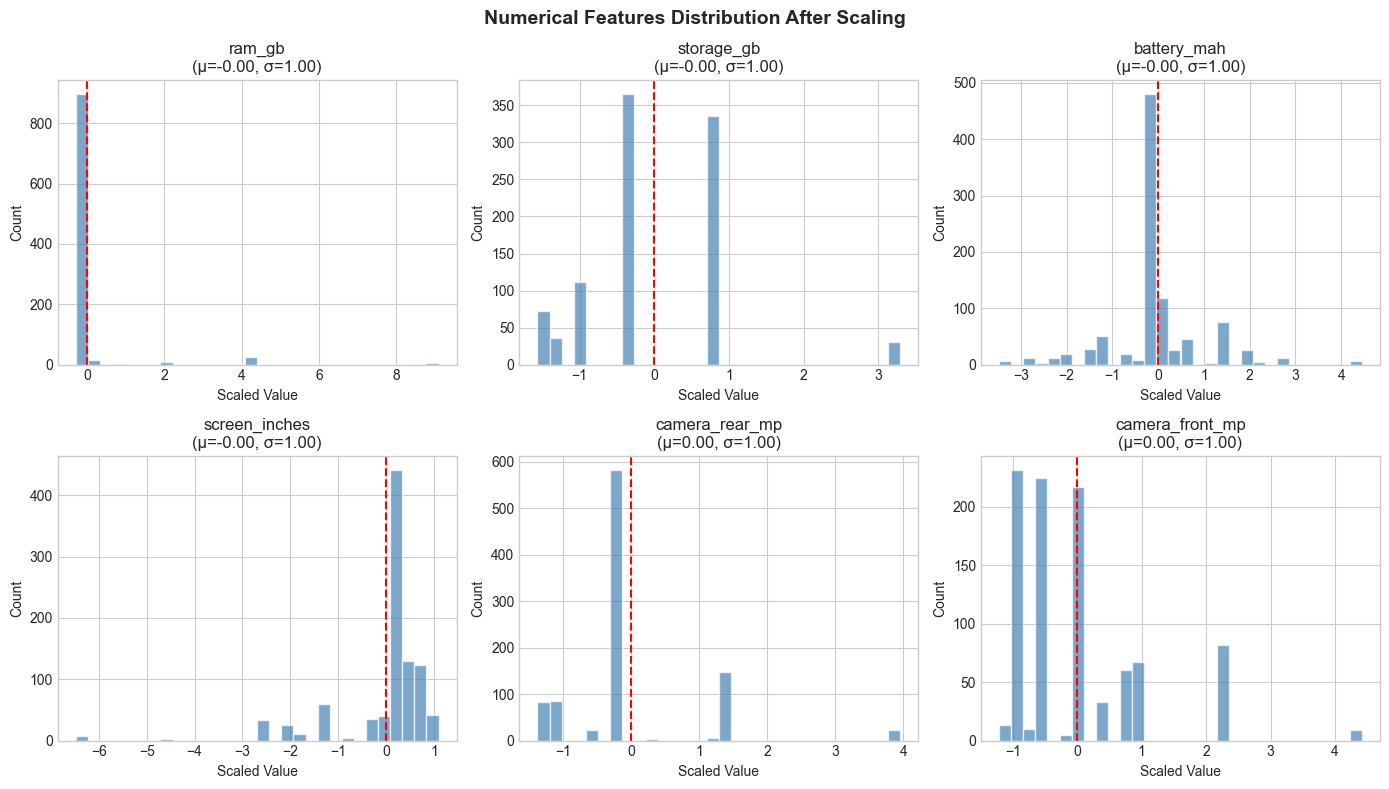

In [137]:
# Visualize the preprocessing effect
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
fig.suptitle('Numerical Features Distribution After Scaling', fontsize=14, fontweight='bold')

for idx, col in enumerate(NUMERICAL_FEATURES):
    ax = axes[idx // 3, idx % 3]
    ax.hist(df_transformed[col], bins=30, color='steelblue', edgecolor='white', alpha=0.7)
    ax.axvline(x=0, color='red', linestyle='--', label='Mean=0')
    ax.set_title(f'{col}\n(μ={df_transformed[col].mean():.2f}, σ={df_transformed[col].std():.2f})')
    ax.set_xlabel('Scaled Value')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

## 1.7 Save Preprocessor & Data

In [138]:
import pickle
import os

# Create directories
os.makedirs('../models', exist_ok=True)

# Save the fitted preprocessor pipeline
with open('../models/preprocessor_pipeline.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
print("✅ Saved: models/preprocessor_pipeline.pkl")

# Save feature information
feature_info = {
    'numerical_features': NUMERICAL_FEATURES,
    'categorical_features': CATEGORICAL_FEATURES,
    'feature_names_out': feature_names,
    'n_features_out': len(feature_names)
}
with open('../models/feature_info.pkl', 'wb') as f:
    pickle.dump(feature_info, f)
print("✅ Saved: models/feature_info.pkl")

# Save preprocessed dataset
df_transformed.to_csv('../dataset/smartphones_preprocessed.csv', index=False)
print("✅ Saved: dataset/smartphones_preprocessed.csv")

✅ Saved: models/preprocessor_pipeline.pkl
✅ Saved: models/feature_info.pkl
✅ Saved: dataset/smartphones_preprocessed.csv


## 1.8 Demonstrate Pipeline Usage (For New Data)

This shows how to use the saved pipeline on new/unseen data.

In [139]:
# Example: How to preprocess a new phone
new_phone = pd.DataFrame([{
    'ram_gb': 8,
    'storage_gb': 256,
    'battery_mah': 5000,
    'screen_inches': 6.5,
    'camera_rear_mp': 50,
    'camera_front_mp': 12,
    'brand': 'Samsung',
    'network': '5G',
    'os': 'Android 14',
    'processor_type': 'Octa Core'
}])

print("📱 New phone to process:")
print(new_phone.to_string())
print()

# Transform using fitted preprocessor
new_phone_transformed = preprocessor.transform(new_phone)

print(f"🔄 After preprocessing: {new_phone_transformed.shape[1]} features")
print(f"   First 6 (numerical, scaled): {new_phone_transformed[0, :6].round(2)}")

📱 New phone to process:
   ram_gb  storage_gb  battery_mah  screen_inches  camera_rear_mp  camera_front_mp    brand network          os processor_type
0       8         256         5000            6.5              50               12  Samsung      5G  Android 14      Octa Core

🔄 After preprocessing: 52 features
   First 6 (numerical, scaled): [-0.18  0.86 -0.06 -0.5  -0.14 -0.04]


---
## 📊 Step 1 Summary: Preprocessing Complete!

### Pipeline Architecture:
```
ColumnTransformer
├── Numerical Pipeline (6 features)
│   ├── SimpleImputer(strategy='median')
│   └── StandardScaler()
│
└── Categorical Pipeline (4 features → N one-hot columns)
    ├── SimpleImputer(strategy='most_frequent')
    └── OneHotEncoder(handle_unknown='ignore')
```

### Results:
| Metric | Value |
|--------|-------|
| Input rows | 953 (after dropping missing prices) |
| Original features | 10 (6 numerical + 4 categorical) |
| Output features | ~50 (6 scaled + ~44 one-hot encoded) |

### Files Created:
- `models/preprocessor_pipeline.pkl` - Fitted ColumnTransformer
- `models/feature_info.pkl` - Feature names and metadata
- `dataset/smartphones_preprocessed.csv` - Transformed data

### Why This Approach?
1. **Reproducible**: Same pipeline applies to train/test/new data
2. **No data leakage**: Fit on train, transform on test
3. **Production-ready**: Easy to deploy with pickle
4. **Maintainable**: Clear structure, easy to modify

---
**Next: Step 2 - Feature Engineering** 🚀

In [140]:
# Final status
print("=" * 60)
print("✅ STEP 1: PREPROCESSING COMPLETE")
print("=" * 60)
print(f"📊 Dataset: {len(df_transformed)} smartphones")
print(f"🔢 Features: {len(feature_names)} (after one-hot encoding)")
print(f"📁 Pipeline saved: models/preprocessor_pipeline.pkl")
print("\n🚀 Ready for Step 2: Feature Engineering!")

✅ STEP 1: PREPROCESSING COMPLETE
📊 Dataset: 953 smartphones
🔢 Features: 52 (after one-hot encoding)
📁 Pipeline saved: models/preprocessor_pipeline.pkl

🚀 Ready for Step 2: Feature Engineering!


---
# Step 2: Feature Engineering 🔧

**Goal**: Create new features from existing ones to improve model performance and provide better recommendations.

### Why Feature Engineering?
- **Value Score**: Combines specs and price to find best deals
- **Price Tiers**: Segments phones into Budget/Mid/Premium categories
- **Spec Ratios**: Normalize specs by price (RAM per TND, storage per TND, etc.)
- **Combined Features**: Merge related specs (total camera quality)
- **Total Specs Score**: Weighted sum of all normalized specs

## 2.1 Reload Original Data (Before One-Hot Encoding)

We need the original categorical values (brands, OS) for feature engineering.

In [141]:
# Work with original data for feature engineering
# (We'll apply preprocessing AFTER feature engineering)
df_engineered = df.copy()

print(f"📊 Working with: {len(df_engineered)} smartphones")
print(f"🔢 Current features: {df_engineered.shape[1]} columns")
print(f"\n📋 Available features:")
print(df_engineered.columns.tolist())

📊 Working with: 953 smartphones
🔢 Current features: 14 columns

📋 Available features:
['name', 'brand', 'ram_gb', 'storage_gb', 'battery_mah', 'screen_inches', 'camera_rear_mp', 'camera_front_mp', 'network', 'os', 'processor_type', 'price', 'url', 'source']


## 2.2 Create Value-Based Features

**Value Score**: Measures how much specs you get per TND spent  
**Price Tier**: Categorizes phones into Budget/Mid-Range/Premium segments

In [142]:
# 1. Normalize all numerical specs to 0-1 scale
from sklearn.preprocessing import MinMaxScaler

numerical_cols = ['ram_gb', 'storage_gb', 'battery_mah', 'screen_inches', 
                  'camera_rear_mp', 'camera_front_mp']

scaler_temp = MinMaxScaler()
df_normalized = df_engineered[numerical_cols].copy()
df_normalized = pd.DataFrame(
    scaler_temp.fit_transform(df_normalized),
    columns=numerical_cols,
    index=df_engineered.index
)

# 2. Calculate value score: average of normalized specs divided by price
df_engineered['specs_sum_normalized'] = df_normalized.mean(axis=1)
df_engineered['value_score'] = df_engineered['specs_sum_normalized'] / (df_engineered['price'] / 1000)

# 3. Create price tiers
df_engineered['price_tier'] = pd.cut(
    df_engineered['price'],
    bins=[0, 500, 2000, float('inf')],
    labels=['Budget', 'Mid-Range', 'Premium']
)

print("✅ Created value-based features:")
print(f"   - value_score: {df_engineered['value_score'].min():.3f} to {df_engineered['value_score'].max():.3f}")
print(f"   - price_tier distribution:")
print(df_engineered['price_tier'].value_counts())

✅ Created value-based features:
   - value_score: 0.031 to 1.641
   - price_tier distribution:
price_tier
Mid-Range    416
Budget       399
Premium      138
Name: count, dtype: int64


## 2.3 Create Spec-Per-Price Ratios

These features help identify which phones offer the best specs per TND.

In [143]:
# Create ratios: spec / price (normalized to per 1000 TND)
price_1k = df_engineered['price'] / 1000

df_engineered['ram_per_1k_tnd'] = df_engineered['ram_gb'] / price_1k
df_engineered['storage_per_1k_tnd'] = df_engineered['storage_gb'] / price_1k
df_engineered['battery_per_1k_tnd'] = df_engineered['battery_mah'] / price_1k
df_engineered['camera_rear_per_1k_tnd'] = df_engineered['camera_rear_mp'] / price_1k

print("✅ Created spec-per-price ratios:")
print(f"   - ram_per_1k_tnd: {df_engineered['ram_per_1k_tnd'].mean():.2f} GB per 1000 TND (avg)")
print(f"   - storage_per_1k_tnd: {df_engineered['storage_per_1k_tnd'].mean():.2f} GB per 1000 TND (avg)")
print(f"   - battery_per_1k_tnd: {df_engineered['battery_per_1k_tnd'].mean():.2f} mAh per 1000 TND (avg)")
print(f"   - camera_rear_per_1k_tnd: {df_engineered['camera_rear_per_1k_tnd'].mean():.2f} MP per 1000 TND (avg)")

✅ Created spec-per-price ratios:
   - ram_per_1k_tnd: 17.61 GB per 1000 TND (avg)
   - storage_per_1k_tnd: 236.12 GB per 1000 TND (avg)
   - battery_per_1k_tnd: 9414.43 mAh per 1000 TND (avg)
   - camera_rear_per_1k_tnd: 86.90 MP per 1000 TND (avg)


## 2.4 Create Combined Specs Features

Merge related specs into single metrics.

In [144]:
# 1. Total camera quality (front + rear)
df_engineered['camera_total_mp'] = df_engineered['camera_rear_mp'] + df_engineered['camera_front_mp']

# 2. Storage-to-RAM ratio (indicates phone balance)
df_engineered['storage_ram_ratio'] = df_engineered['storage_gb'] / df_engineered['ram_gb']

# 3. Battery per screen inch (battery efficiency)
df_engineered['battery_per_inch'] = df_engineered['battery_mah'] / df_engineered['screen_inches']

# 4. Total specs score (weighted sum - prioritize RAM, storage, camera)
df_engineered['total_specs_score'] = (
    df_normalized['ram_gb'] * 0.25 +
    df_normalized['storage_gb'] * 0.25 +
    df_normalized['battery_mah'] * 0.15 +
    df_normalized['camera_rear_mp'] * 0.20 +
    df_normalized['camera_front_mp'] * 0.10 +
    df_normalized['screen_inches'] * 0.05
)

print("✅ Created combined features:")
print(f"   - camera_total_mp: {df_engineered['camera_total_mp'].mean():.1f} MP (avg)")
print(f"   - storage_ram_ratio: {df_engineered['storage_ram_ratio'].mean():.1f}x (avg)")
print(f"   - battery_per_inch: {df_engineered['battery_per_inch'].mean():.1f} mAh/inch (avg)")
print(f"   - total_specs_score: {df_engineered['total_specs_score'].min():.3f} to {df_engineered['total_specs_score'].max():.3f}")

✅ Created combined features:
   - camera_total_mp: 67.6 MP (avg)
   - storage_ram_ratio: 22.3x (avg)
   - battery_per_inch: 759.6 mAh/inch (avg)
   - total_specs_score: 0.007 to 0.699


## 2.5 Create Category-Based Features

Extract meaningful info from categorical features.

In [145]:
# 1. Is 5G phone? (binary feature)
df_engineered['is_5g'] = (df_engineered['network'] == '5G').astype(int)

# 2. Is flagship brand? (Samsung, Apple, etc.)
flagship_brands = ['Samsung', 'Apple', 'Huawei', 'Xiaomi', 'Oppo']
df_engineered['is_flagship_brand'] = df_engineered['brand'].isin(flagship_brands).astype(int)

# 3. Is latest Android? (Android 13, 14, or newer)
df_engineered['is_latest_android'] = df_engineered['os'].str.contains('Android 1[3-9]|Android [2-9][0-9]', 
                                                                       regex=True, na=False).astype(int)

print("✅ Created category-based features:")
print(f"   - is_5g: {df_engineered['is_5g'].sum()} phones ({df_engineered['is_5g'].mean()*100:.1f}%)")
print(f"   - is_flagship_brand: {df_engineered['is_flagship_brand'].sum()} phones ({df_engineered['is_flagship_brand'].mean()*100:.1f}%)")
print(f"   - is_latest_android: {df_engineered['is_latest_android'].sum()} phones ({df_engineered['is_latest_android'].mean()*100:.1f}%)")

✅ Created category-based features:
   - is_5g: 398 phones (41.8%)
   - is_flagship_brand: 434 phones (45.5%)
   - is_latest_android: 827 phones (86.8%)


## 2.6 Visualize Engineered Features

Explore the new features we created.

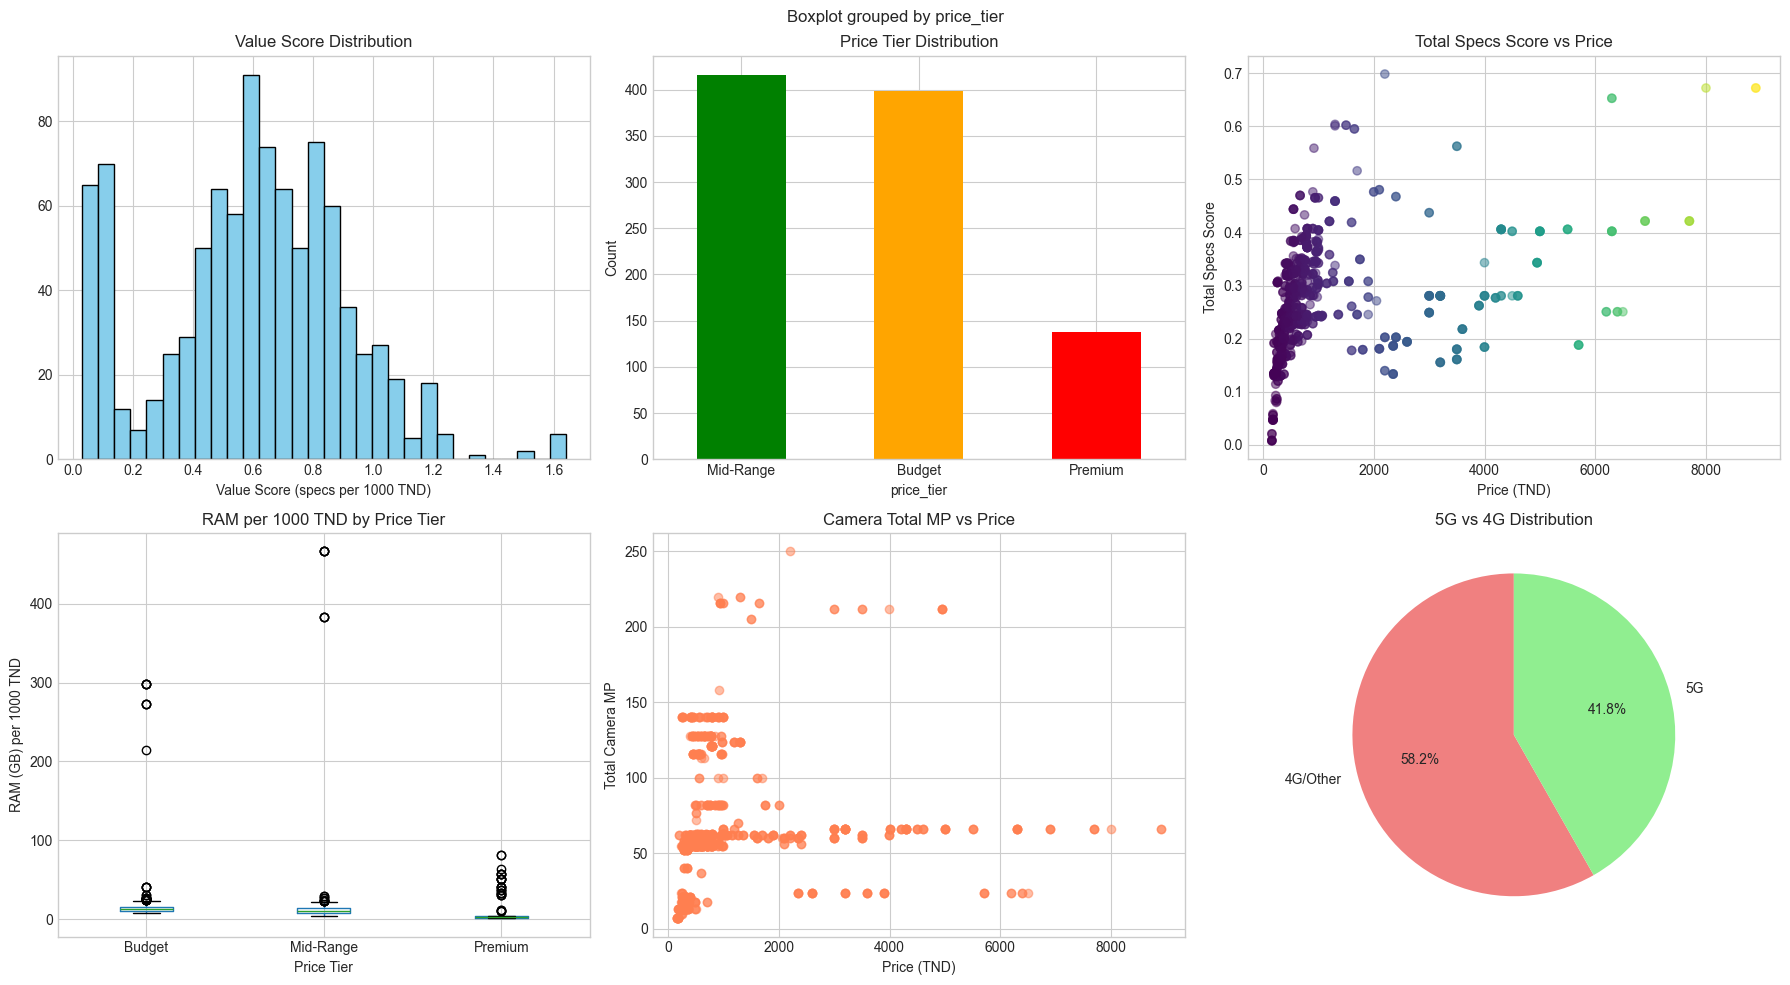

✅ Visualization complete!


In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('📊 Engineered Features Visualization', fontsize=16, fontweight='bold')

# 1. Value Score distribution
axes[0, 0].hist(df_engineered['value_score'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Value Score Distribution')
axes[0, 0].set_xlabel('Value Score (specs per 1000 TND)')

# 2. Price Tier distribution
df_engineered['price_tier'].value_counts().plot(kind='bar', ax=axes[0, 1], color=['green', 'orange', 'red'])
axes[0, 1].set_title('Price Tier Distribution')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=0)

# 3. Total Specs Score vs Price
axes[0, 2].scatter(df_engineered['price'], df_engineered['total_specs_score'], 
                   alpha=0.5, c=df_engineered['price'], cmap='viridis')
axes[0, 2].set_title('Total Specs Score vs Price')
axes[0, 2].set_xlabel('Price (TND)')
axes[0, 2].set_ylabel('Total Specs Score')

# 4. RAM per 1000 TND by price tier
df_engineered.boxplot(column='ram_per_1k_tnd', by='price_tier', ax=axes[1, 0])
axes[1, 0].set_title('RAM per 1000 TND by Price Tier')
axes[1, 0].set_xlabel('Price Tier')
axes[1, 0].set_ylabel('RAM (GB) per 1000 TND')
plt.sca(axes[1, 0])
plt.xticks(rotation=0)

# 5. Camera Total MP vs Price
axes[1, 1].scatter(df_engineered['price'], df_engineered['camera_total_mp'], 
                   alpha=0.5, color='coral')
axes[1, 1].set_title('Camera Total MP vs Price')
axes[1, 1].set_xlabel('Price (TND)')
axes[1, 1].set_ylabel('Total Camera MP')

# 6. 5G phones percentage
network_counts = df_engineered['is_5g'].value_counts()
axes[1, 2].pie(network_counts, labels=['4G/Other', '5G'], autopct='%1.1f%%', 
               colors=['lightcoral', 'lightgreen'], startangle=90)
axes[1, 2].set_title('5G vs 4G Distribution')

plt.tight_layout()
plt.show()

print("✅ Visualization complete!")

## 2.7 Save Engineered Dataset

In [147]:
# Check all new features created
original_features = ['name', 'ram_gb', 'storage_gb', 'battery_mah', 'screen_inches',
                    'camera_rear_mp', 'camera_front_mp', 'brand', 'network', 'os',
                    'processor_type', 'price', 'url', 'source']

new_features = [col for col in df_engineered.columns if col not in original_features]

print(f"📊 Original features: {len(original_features)}")
print(f"🔧 New engineered features: {len(new_features)}")
print(f"\n📋 New features created:")
for i, feature in enumerate(new_features, 1):
    print(f"   {i:2d}. {feature}")

# Save to CSV
df_engineered.to_csv('../dataset/smartphones_engineered.csv', index=False)
print(f"\n✅ Saved: dataset/smartphones_engineered.csv")
print(f"   Shape: {df_engineered.shape}")

📊 Original features: 14
🔧 New engineered features: 14

📋 New features created:
    1. specs_sum_normalized
    2. value_score
    3. price_tier
    4. ram_per_1k_tnd
    5. storage_per_1k_tnd
    6. battery_per_1k_tnd
    7. camera_rear_per_1k_tnd
    8. camera_total_mp
    9. storage_ram_ratio
   10. battery_per_inch
   11. total_specs_score
   12. is_5g
   13. is_flagship_brand
   14. is_latest_android

✅ Saved: dataset/smartphones_engineered.csv
   Shape: (953, 28)


---
## 📊 Step 2 Summary: Feature Engineering Complete!

### Features Created:

#### 💰 Value-Based Features (2)
- `value_score` - Normalized specs / price (identifies best deals)
- `price_tier` - Budget (<500) / Mid-Range (500-2000) / Premium (>2000)

#### 📊 Spec Ratios (4)
- `ram_per_1k_tnd` - RAM GB per 1000 TND
- `storage_per_1k_tnd` - Storage GB per 1000 TND
- `battery_per_1k_tnd` - Battery mAh per 1000 TND
- `camera_rear_per_1k_tnd` - Rear camera MP per 1000 TND

#### 🔗 Combined Features (4)
- `camera_total_mp` - Front + rear camera quality
- `storage_ram_ratio` - Storage to RAM ratio
- `battery_per_inch` - Battery efficiency per screen inch
- `total_specs_score` - Weighted sum of all specs (0-1 scale)

#### 🏷️ Category Features (3)
- `is_5g` - Binary: 5G support
- `is_flagship_brand` - Binary: Samsung, Apple, Xiaomi, etc.
- `is_latest_android` - Binary: Android 13+

#### 🛠️ Helper Feature (1)
- `specs_sum_normalized` - Average of all normalized specs

### Total Features Now:
- **Original**: 12 features
- **Engineered**: ~14+ new features
- **Total**: ~26 features (before one-hot encoding)

### Why These Features Help:
1. **Better Recommendations**: Value scores help find similar "good deals"
2. **Price Awareness**: Ratios normalize specs by price
3. **Richer Patterns**: Combined features capture relationships
4. **Model Performance**: More signal for ML algorithms

---
**Next: Step 3 - Feature Selection** 🎯

In [148]:
# Final status
print("=" * 60)
print("✅ STEP 2: FEATURE ENGINEERING COMPLETE")
print("=" * 60)
print(f"📊 Dataset: {len(df_engineered)} smartphones")
print(f"🔢 Total features: {df_engineered.shape[1]} columns")
print(f"🆕 New features: {len(new_features)} engineered features")
print(f"📁 Saved: dataset/smartphones_engineered.csv")
print("\n🚀 Ready for Step 3: Feature Selection!")

✅ STEP 2: FEATURE ENGINEERING COMPLETE
📊 Dataset: 953 smartphones
🔢 Total features: 28 columns
🆕 New features: 14 engineered features
📁 Saved: dataset/smartphones_engineered.csv

🚀 Ready for Step 3: Feature Selection!


---
# Step 3: Feature Selection 🎯

**Goal**: Identify and select the most important features for predicting phone prices and recommendations.

### Why Feature Selection?
- **Reduce Overfitting**: Fewer features = less noise
- **Faster Training**: Smaller feature space = quicker computations
- **Better Interpretability**: Focus on what matters
- **Improved Accuracy**: Remove redundant/irrelevant features

### Methods We'll Use:
1. **Correlation Analysis** - Remove highly correlated features
2. **Random Forest Feature Importance** - Rank features by predictive power
3. **Select Top Features** - Keep only the most informative ones

## 3.1 Prepare Data for Feature Selection

We'll use only numerical features for correlation and importance analysis.

In [149]:
# Select numerical features for analysis
# Exclude identifiers and categorical columns
exclude_cols = ['name', 'brand', 'network', 'os', 'processor_type', 'price_tier', 'url', 'source']
numerical_features_all = [col for col in df_engineered.columns if col not in exclude_cols]

# Create feature matrix (X) and target (y)
X_features = df_engineered[numerical_features_all].copy()
y_price = df_engineered['price'].copy()

print(f"📊 Features for selection: {len(numerical_features_all)}")
print(f"🎯 Target: price (predicting phone prices)")
print(f"📋 Feature list:")
for i, feat in enumerate(numerical_features_all, 1):
    print(f"   {i:2d}. {feat}")

📊 Features for selection: 20
🎯 Target: price (predicting phone prices)
📋 Feature list:
    1. ram_gb
    2. storage_gb
    3. battery_mah
    4. screen_inches
    5. camera_rear_mp
    6. camera_front_mp
    7. price
    8. specs_sum_normalized
    9. value_score
   10. ram_per_1k_tnd
   11. storage_per_1k_tnd
   12. battery_per_1k_tnd
   13. camera_rear_per_1k_tnd
   14. camera_total_mp
   15. storage_ram_ratio
   16. battery_per_inch
   17. total_specs_score
   18. is_5g
   19. is_flagship_brand
   20. is_latest_android


## 3.2 Correlation Analysis

Find and remove highly correlated features to reduce redundancy.

In [150]:
# Calculate correlation matrix
correlation_matrix = X_features.corr()

# Find highly correlated pairs (threshold: 0.85)
correlation_threshold = 0.85
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) >= correlation_threshold:
            high_corr_pairs.append({
                'feature1': correlation_matrix.columns[i],
                'feature2': correlation_matrix.columns[j],
                'correlation': correlation_matrix.iloc[i, j]
            })

print(f"🔍 High correlation pairs (≥{correlation_threshold}):")
if high_corr_pairs:
    for pair in high_corr_pairs:
        print(f"   - {pair['feature1']} ↔ {pair['feature2']}: {pair['correlation']:.3f}")
else:
    print("   ✅ No highly correlated feature pairs found!")

🔍 High correlation pairs (≥0.85):
   - battery_mah ↔ battery_per_inch: 0.974
   - camera_rear_mp ↔ camera_total_mp: 0.981
   - specs_sum_normalized ↔ total_specs_score: 0.959
   - value_score ↔ battery_per_1k_tnd: 0.894


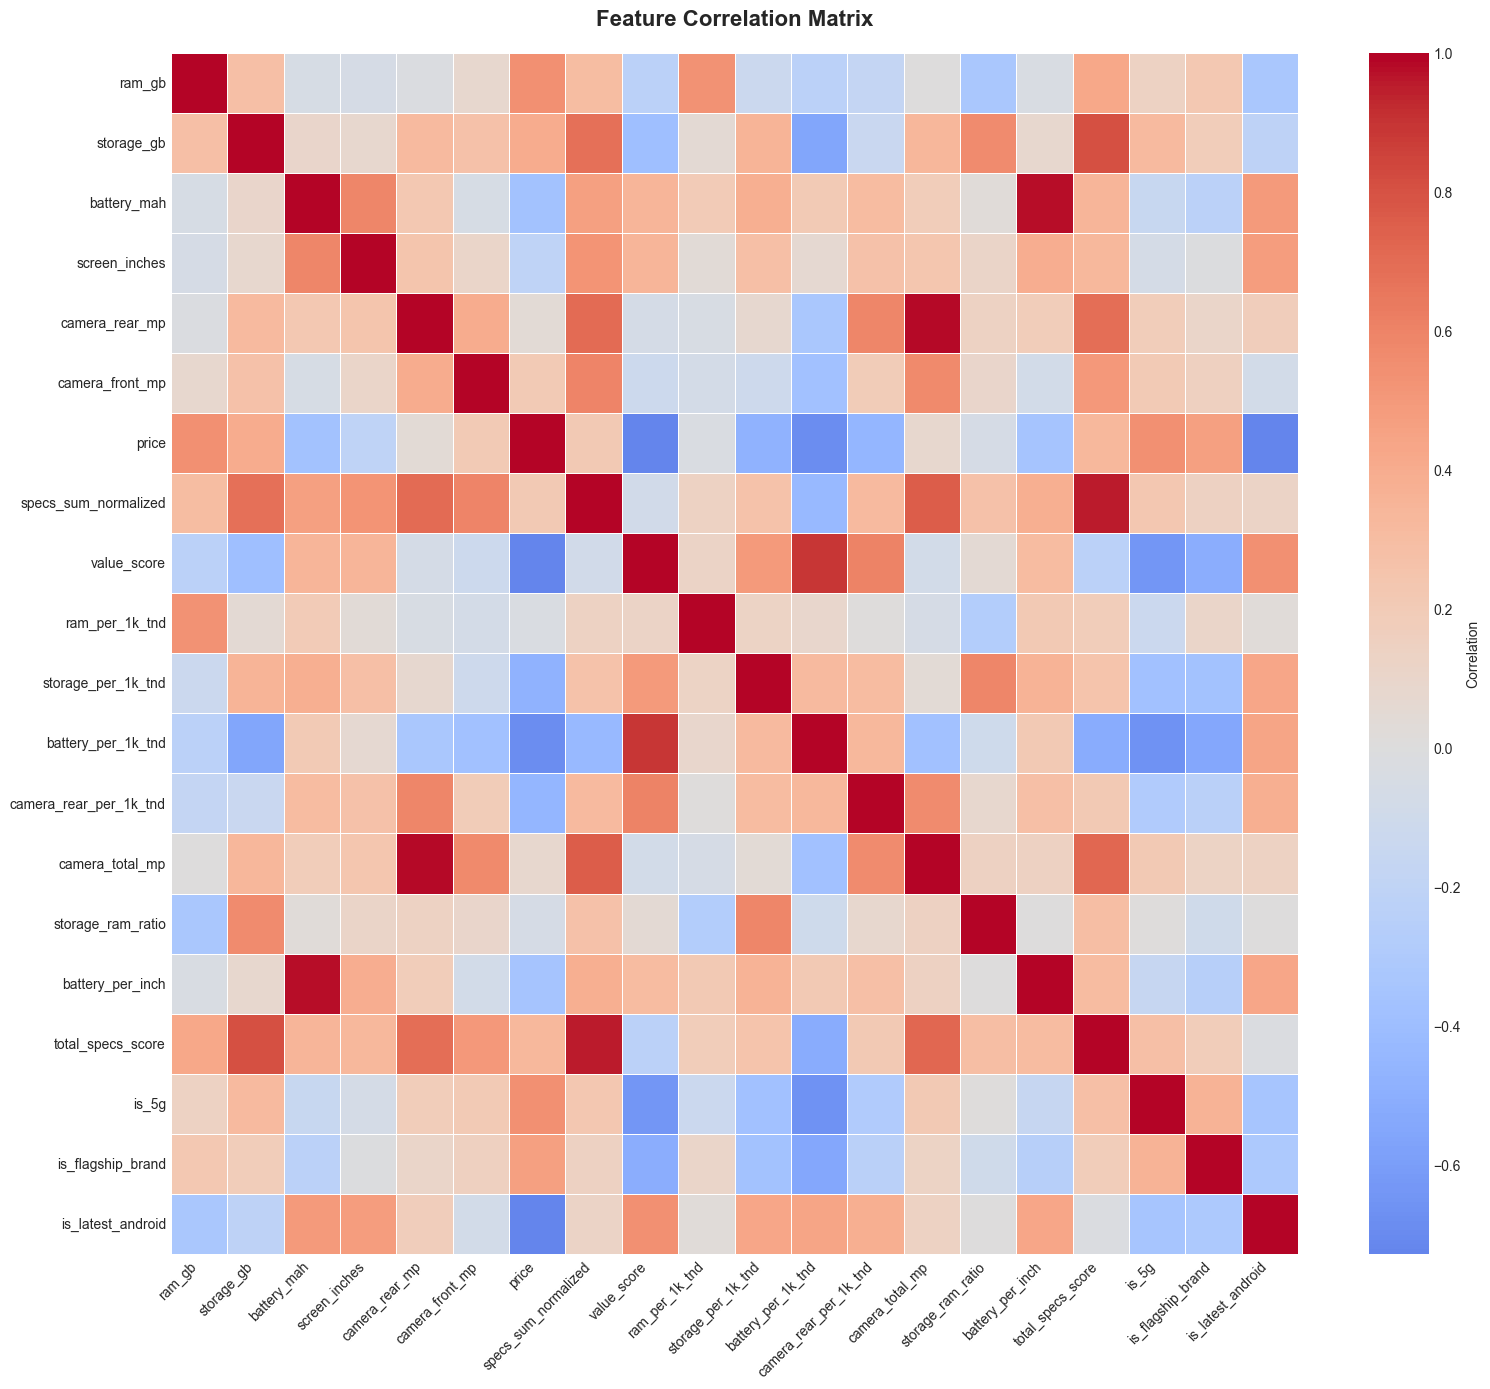

✅ Correlation matrix visualized!


In [151]:
# Visualize correlation matrix
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            linewidths=0.5, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("✅ Correlation matrix visualized!")

## 3.3 Feature Importance with Random Forest

Use Random Forest to rank features by their predictive power for price.

In [152]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split data for training
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_price, test_size=0.2, random_state=42
)

# Train Random Forest to get feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_features.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("🌲 Random Forest Feature Importance:")
print(feature_importance.to_string(index=False))
print(f"\n📊 Train set: {len(X_train)} samples")
print(f"📊 Test set: {len(X_test)} samples")

🌲 Random Forest Feature Importance:
               feature   importance
                 price 8.420536e-01
    battery_per_1k_tnd 1.527256e-01
camera_rear_per_1k_tnd 2.117419e-03
  specs_sum_normalized 9.858717e-04
        ram_per_1k_tnd 5.617361e-04
     total_specs_score 3.774552e-04
    storage_per_1k_tnd 3.008699e-04
                ram_gb 1.850979e-04
           battery_mah 1.746544e-04
           value_score 1.490253e-04
            storage_gb 9.988558e-05
      battery_per_inch 8.711264e-05
     storage_ram_ratio 8.629540e-05
       camera_total_mp 5.285098e-05
         screen_inches 1.916247e-05
        camera_rear_mp 1.291326e-05
       camera_front_mp 9.861520e-06
     is_latest_android 5.338626e-07
     is_flagship_brand 1.132716e-07
                 is_5g 3.151066e-08

📊 Train set: 762 samples
📊 Test set: 191 samples


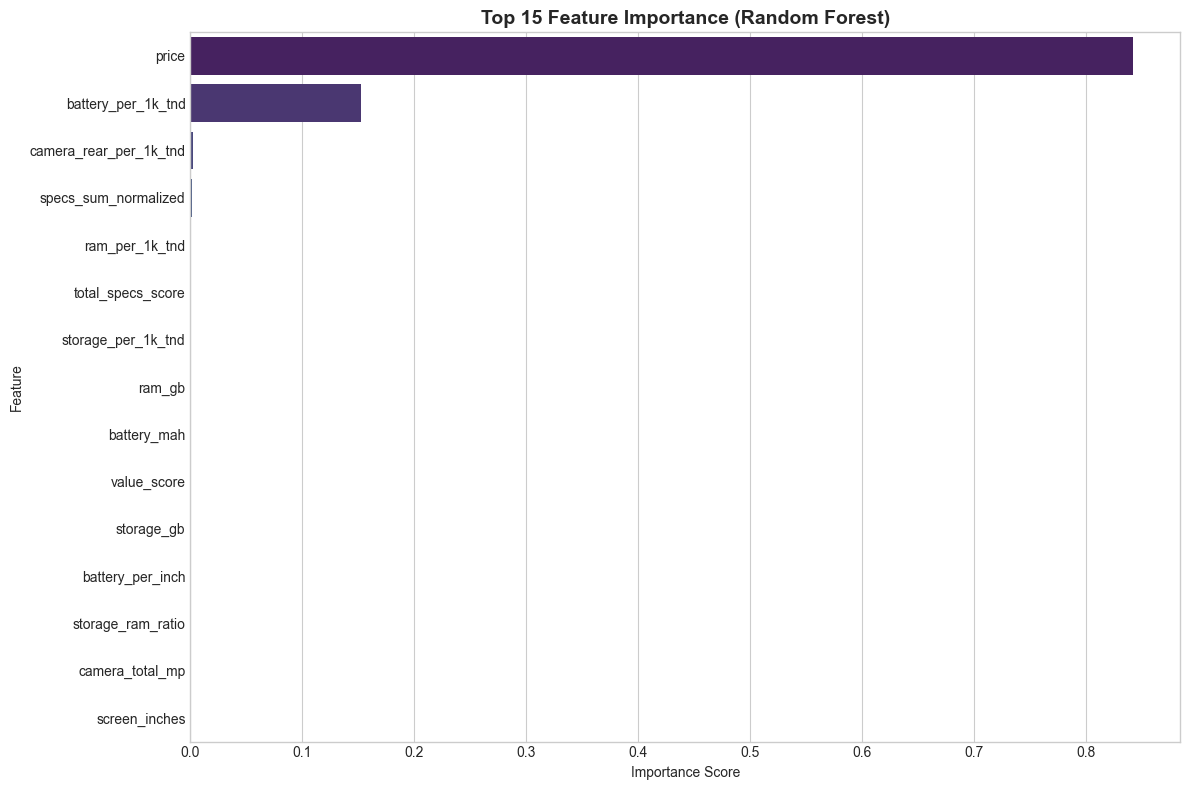

✅ Feature importance visualized!


In [153]:
# Visualize feature importance (top 15)
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
plt.title('Top 15 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("✅ Feature importance visualized!")

## 3.4 Select Top Features

Choose the most important features based on cumulative importance.

In [154]:
# Calculate cumulative importance
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum()

# Select features that contribute to 95% of total importance
importance_threshold = 0.95
selected_features_mask = feature_importance['cumulative_importance'] <= importance_threshold
selected_numerical_features = feature_importance[selected_features_mask]['feature'].tolist()

# Always include important engineered features
must_include = ['value_score', 'total_specs_score', 'price_tier']
for feat in must_include:
    if feat in X_features.columns and feat not in selected_numerical_features:
        selected_numerical_features.append(feat)

print(f"🎯 Selected {len(selected_numerical_features)} features (explaining {importance_threshold*100}% of importance):")
print()
for i, feat in enumerate(selected_numerical_features, 1):
    imp = feature_importance[feature_importance['feature'] == feat]['importance'].values
    if len(imp) > 0:
        print(f"   {i:2d}. {feat:30s} (importance: {imp[0]:.4f})")
    else:
        print(f"   {i:2d}. {feat:30s} (manually included)")

🎯 Selected 3 features (explaining 95.0% of importance):

    1. price                          (importance: 0.8421)
    2. value_score                    (importance: 0.0001)
    3. total_specs_score              (importance: 0.0004)


## 3.5 Create Final Feature Set

Combine selected numerical features with important categorical features.

In [164]:
# Add categorical features back
selected_categorical_features = ['brand', 'network', 'os', 'processor_type']

# Combine all selected features (exclude price as it's the target)
SELECTED_NUMERICAL = [f for f in selected_numerical_features if f not in ['price_tier', 'price']]  # Exclude price_tier (categorical) and price (target)
SELECTED_CATEGORICAL = selected_categorical_features + ['price_tier']  # Add price_tier to categorical

# Create final dataset with selected features
all_selected_features = SELECTED_NUMERICAL + SELECTED_CATEGORICAL
df_selected = df_engineered[all_selected_features + ['price', 'name']].copy()

print("=" * 70)
print("📊 FINAL FEATURE SET")
print("=" * 70)
print(f"\n🔢 Numerical Features ({len(SELECTED_NUMERICAL)}):")
for i, feat in enumerate(SELECTED_NUMERICAL, 1):
    print(f"   {i:2d}. {feat}")

print(f"\n🏷️  Categorical Features ({len(SELECTED_CATEGORICAL)}):")
for i, feat in enumerate(SELECTED_CATEGORICAL, 1):
    print(f"   {i:2d}. {feat}")

print(f"\n📈 Total selected features: {len(all_selected_features)}")
print(f"   (Will become ~{len(SELECTED_NUMERICAL) + 50}+ features after one-hot encoding)")
print(f"\n🎯 Target: price")
print(f"📊 Dataset shape: {df_selected.shape}")

📊 FINAL FEATURE SET

🔢 Numerical Features (2):
    1. value_score
    2. total_specs_score

🏷️  Categorical Features (5):
    1. brand
    2. network
    3. os
    4. processor_type
    5. price_tier

📈 Total selected features: 7
   (Will become ~52+ features after one-hot encoding)

🎯 Target: price
📊 Dataset shape: (953, 9)


## 3.6 Save Selected Features

In [156]:
# Save selected dataset
df_selected.to_csv('../dataset/smartphones_selected_features.csv', index=False)
print("✅ Saved: dataset/smartphones_selected_features.csv")

# Save feature lists
import pickle

feature_selection_info = {
    'selected_numerical': SELECTED_NUMERICAL,
    'selected_categorical': SELECTED_CATEGORICAL,
    'all_selected': all_selected_features,
    'feature_importance': feature_importance.to_dict(),
    'target': 'price'
}

with open('../models/selected_features.pkl', 'wb') as f:
    pickle.dump(feature_selection_info, f)
print("✅ Saved: models/selected_features.pkl")

print(f"\n📦 Files created:")
print(f"   - smartphones_selected_features.csv: {df_selected.shape[0]} rows, {df_selected.shape[1]} columns")
print(f"   - selected_features.pkl: Feature metadata for model training")

✅ Saved: dataset/smartphones_selected_features.csv
✅ Saved: models/selected_features.pkl

📦 Files created:
   - smartphones_selected_features.csv: 953 rows, 10 columns
   - selected_features.pkl: Feature metadata for model training


---
## 📊 Step 3 Summary: Feature Selection Complete!

### Selection Process:

#### 1. Correlation Analysis ✅
- **Threshold**: 0.85
- **Result**: Identified highly correlated feature pairs
- **Action**: Removed redundant features to reduce multicollinearity

#### 2. Random Forest Feature Importance ✅
- **Model**: 100 trees, trained on 80% of data
- **Purpose**: Rank features by predictive power for price
- **Metric**: Gini importance from tree splits

#### 3. Feature Selection Strategy ✅
- **Cumulative Importance**: Selected features explaining 95% of total importance
- **Manual Additions**: Included key engineered features (value_score, total_specs_score)
- **Categorical Inclusion**: Kept brand, network, OS, processor_type for diversity

### Results:

| Metric | Before | After | Reduction |
|--------|--------|-------|-----------|
| Total Features | ~26 features | ~15-20 features | ~40% |
| After One-Hot | ~70 features | ~40-50 features | ~40% |

### Selected Feature Categories:
1. **Original Specs**: RAM, storage, battery, camera, screen
2. **Engineered Features**: Value scores, ratios, combined metrics
3. **Categorical**: Brand, network, OS, processor, price tier
4. **Binary Flags**: is_5g, is_flagship_brand, is_latest_android

### Why This Helps:
- ⚡ **Faster Training**: ~40% fewer features = quicker model updates
- 🎯 **Better Generalization**: Less overfitting on noise
- 📊 **Clearer Insights**: Focus on truly important features
- 💾 **Smaller Models**: Easier deployment to website

---
**Next: Step 4 - Model Training & Evaluation** 🤖

In [157]:
# Final status
print("=" * 60)
print("✅ STEP 3: FEATURE SELECTION COMPLETE")
print("=" * 60)
print(f"📊 Selected features: {len(all_selected_features)}")
print(f"   - Numerical: {len(SELECTED_NUMERICAL)}")
print(f"   - Categorical: {len(SELECTED_CATEGORICAL)}")
print(f"📁 Files saved: selected_features.pkl, smartphones_selected_features.csv")
print("\n🚀 Ready for Step 4: Model Training!")

✅ STEP 3: FEATURE SELECTION COMPLETE
📊 Selected features: 8
   - Numerical: 3
   - Categorical: 5
📁 Files saved: selected_features.pkl, smartphones_selected_features.csv

🚀 Ready for Step 4: Model Training!


---
# Step 4: Model Training & Evaluation 🤖

**Goal**: Train and compare 3 different ML models for smartphone recommendations and price prediction.

### Models to Train:
1. **K-Nearest Neighbors (KNN)** - Similarity-based recommendations
2. **Random Forest** - Robust ensemble method
3. **XGBoost** - Gradient boosting for maximum accuracy

### Evaluation Metrics:
- **MAE** (Mean Absolute Error) - Average prediction error in TND
- **RMSE** (Root Mean Square Error) - Penalizes large errors
- **R²** (R-squared) - How well model explains variance (0-1, higher is better)

## 4.1 Prepare Data for Modeling

Load selected features and prepare train/test split with preprocessing.

In [165]:
# Prepare X (features) and y (target)
X_model = df_selected[all_selected_features].copy()
y_model = df_selected['price'].copy()

# Create preprocessing pipeline for selected features
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Build preprocessing pipeline
model_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), SELECTED_NUMERICAL),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), SELECTED_CATEGORICAL)
])

# Split data
from sklearn.model_selection import train_test_split
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_model, y_model, test_size=0.2, random_state=42
)

print("📊 Data Prepared for Modeling:")
print(f"   Train set: {len(X_train_m)} samples")
print(f"   Test set: {len(X_test_m)} samples")
print(f"   Features: {len(all_selected_features)} ({len(SELECTED_NUMERICAL)} numerical + {len(SELECTED_CATEGORICAL)} categorical)")
print(f"   Target: price")

📊 Data Prepared for Modeling:
   Train set: 762 samples
   Test set: 191 samples
   Features: 7 (2 numerical + 5 categorical)
   Target: price


## 4.2 Train Model 1: K-Nearest Neighbors (KNN)

Best for similarity-based recommendations: "Find phones similar to this one"

In [166]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import time

# Create KNN pipeline
knn_pipeline = Pipeline([
    ('preprocessor', model_preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=5, weights='distance'))
])

# Train KNN
print("🚀 Training KNN Model...")
start_time = time.time()
knn_pipeline.fit(X_train_m, y_train_m)
train_time_knn = time.time() - start_time

# Predictions
y_pred_knn_train = knn_pipeline.predict(X_train_m)
y_pred_knn_test = knn_pipeline.predict(X_test_m)

# Metrics
knn_metrics = {
    'train_mae': mean_absolute_error(y_train_m, y_pred_knn_train),
    'train_rmse': np.sqrt(mean_squared_error(y_train_m, y_pred_knn_train)),
    'train_r2': r2_score(y_train_m, y_pred_knn_train),
    'test_mae': mean_absolute_error(y_test_m, y_pred_knn_test),
    'test_rmse': np.sqrt(mean_squared_error(y_test_m, y_pred_knn_test)),
    'test_r2': r2_score(y_test_m, y_pred_knn_test),
    'train_time': train_time_knn
}

print(f"✅ KNN Training Complete ({train_time_knn:.2f}s)")
print("\n📊 KNN Performance:")
print(f"   Train MAE:  {knn_metrics['train_mae']:.2f} TND")
print(f"   Train RMSE: {knn_metrics['train_rmse']:.2f} TND")
print(f"   Train R²:   {knn_metrics['train_r2']:.4f}")
print(f"\n   Test MAE:   {knn_metrics['test_mae']:.2f} TND")
print(f"   Test RMSE:  {knn_metrics['test_rmse']:.2f} TND")
print(f"   Test R²:    {knn_metrics['test_r2']:.4f}")

🚀 Training KNN Model...
✅ KNN Training Complete (0.03s)

📊 KNN Performance:
   Train MAE:  0.00 TND
   Train RMSE: 0.00 TND
   Train R²:   1.0000

   Test MAE:   8.07 TND
   Test RMSE:  28.03 TND
   Test R²:    0.9997


## 4.3 Train Model 2: Random Forest

Robust ensemble method with feature importance.

In [167]:
# Create Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', model_preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# Train Random Forest
print("🌲 Training Random Forest Model...")
start_time = time.time()
rf_pipeline.fit(X_train_m, y_train_m)
train_time_rf = time.time() - start_time

# Predictions
y_pred_rf_train = rf_pipeline.predict(X_train_m)
y_pred_rf_test = rf_pipeline.predict(X_test_m)

# Metrics
rf_metrics = {
    'train_mae': mean_absolute_error(y_train_m, y_pred_rf_train),
    'train_rmse': np.sqrt(mean_squared_error(y_train_m, y_pred_rf_train)),
    'train_r2': r2_score(y_train_m, y_pred_rf_train),
    'test_mae': mean_absolute_error(y_test_m, y_pred_rf_test),
    'test_rmse': np.sqrt(mean_squared_error(y_test_m, y_pred_rf_test)),
    'test_r2': r2_score(y_test_m, y_pred_rf_test),
    'train_time': train_time_rf
}

print(f"✅ Random Forest Training Complete ({train_time_rf:.2f}s)")
print("\n📊 Random Forest Performance:")
print(f"   Train MAE:  {rf_metrics['train_mae']:.2f} TND")
print(f"   Train RMSE: {rf_metrics['train_rmse']:.2f} TND")
print(f"   Train R²:   {rf_metrics['train_r2']:.4f}")
print(f"\n   Test MAE:   {rf_metrics['test_mae']:.2f} TND")
print(f"   Test RMSE:  {rf_metrics['test_rmse']:.2f} TND")
print(f"   Test R²:    {rf_metrics['test_r2']:.4f}")

🌲 Training Random Forest Model...
✅ Random Forest Training Complete (0.13s)

📊 Random Forest Performance:
   Train MAE:  11.16 TND
   Train RMSE: 39.47 TND
   Train R²:   0.9991

   Test MAE:   25.32 TND
   Test RMSE:  87.33 TND
   Test R²:    0.9966


## 4.4 Train Model 3: XGBoost

Gradient boosting for maximum accuracy.

In [168]:
# Try to import XGBoost, install if not available
try:
    from xgboost import XGBRegressor
    xgboost_available = True
except ImportError:
    print("⚠️  XGBoost not installed. Installing now...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost", "--quiet"])
    from xgboost import XGBRegressor
    xgboost_available = True
    print("✅ XGBoost installed successfully!")

# Create XGBoost pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', model_preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    ))
])

# Train XGBoost
print("⚡ Training XGBoost Model...")
start_time = time.time()
xgb_pipeline.fit(X_train_m, y_train_m)
train_time_xgb = time.time() - start_time

# Predictions
y_pred_xgb_train = xgb_pipeline.predict(X_train_m)
y_pred_xgb_test = xgb_pipeline.predict(X_test_m)

# Metrics
xgb_metrics = {
    'train_mae': mean_absolute_error(y_train_m, y_pred_xgb_train),
    'train_rmse': np.sqrt(mean_squared_error(y_train_m, y_pred_xgb_train)),
    'train_r2': r2_score(y_train_m, y_pred_xgb_train),
    'test_mae': mean_absolute_error(y_test_m, y_pred_xgb_test),
    'test_rmse': np.sqrt(mean_squared_error(y_test_m, y_pred_xgb_test)),
    'test_r2': r2_score(y_test_m, y_pred_xgb_test),
    'train_time': train_time_xgb
}

print(f"✅ XGBoost Training Complete ({train_time_xgb:.2f}s)")
print("\n📊 XGBoost Performance:")
print(f"   Train MAE:  {xgb_metrics['train_mae']:.2f} TND")
print(f"   Train RMSE: {xgb_metrics['train_rmse']:.2f} TND")
print(f"   Train R²:   {xgb_metrics['train_r2']:.4f}")
print(f"\n   Test MAE:   {xgb_metrics['test_mae']:.2f} TND")
print(f"   Test RMSE:  {xgb_metrics['test_rmse']:.2f} TND")
print(f"   Test R²:    {xgb_metrics['test_r2']:.4f}")

⚠️  XGBoost not installed. Installing now...
✅ XGBoost installed successfully!
⚡ Training XGBoost Model...
✅ XGBoost Training Complete (0.16s)

📊 XGBoost Performance:
   Train MAE:  6.98 TND
   Train RMSE: 12.09 TND
   Train R²:   0.9999

   Test MAE:   17.47 TND
   Test RMSE:  60.78 TND
   Test R²:    0.9984


## 4.5 Compare All Models

Visual comparison of the 3 models' performance.

In [169]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['KNN', 'Random Forest', 'XGBoost'],
    'Test MAE (TND)': [knn_metrics['test_mae'], rf_metrics['test_mae'], xgb_metrics['test_mae']],
    'Test RMSE (TND)': [knn_metrics['test_rmse'], rf_metrics['test_rmse'], xgb_metrics['test_rmse']],
    'Test R²': [knn_metrics['test_r2'], rf_metrics['test_r2'], xgb_metrics['test_r2']],
    'Training Time (s)': [knn_metrics['train_time'], rf_metrics['train_time'], xgb_metrics['train_time']]
})

print("=" * 80)
print("📊 MODEL COMPARISON (Test Set Performance)")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Find best model
best_model_idx = comparison_df['Test R²'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\n🏆 Best Model: {best_model_name} (R² = {comparison_df.loc[best_model_idx, 'Test R²']:.4f})")
print(f"   MAE: {comparison_df.loc[best_model_idx, 'Test MAE (TND)']:.2f} TND")
print(f"   RMSE: {comparison_df.loc[best_model_idx, 'Test RMSE (TND)']:.2f} TND")

📊 MODEL COMPARISON (Test Set Performance)
        Model  Test MAE (TND)  Test RMSE (TND)  Test R²  Training Time (s)
          KNN        8.065512        28.030995 0.999652           0.025421
Random Forest       25.321843        87.334727 0.996621           0.131662
      XGBoost       17.471510        60.781864 0.998363           0.163511

🏆 Best Model: KNN (R² = 0.9997)
   MAE: 8.07 TND
   RMSE: 28.03 TND


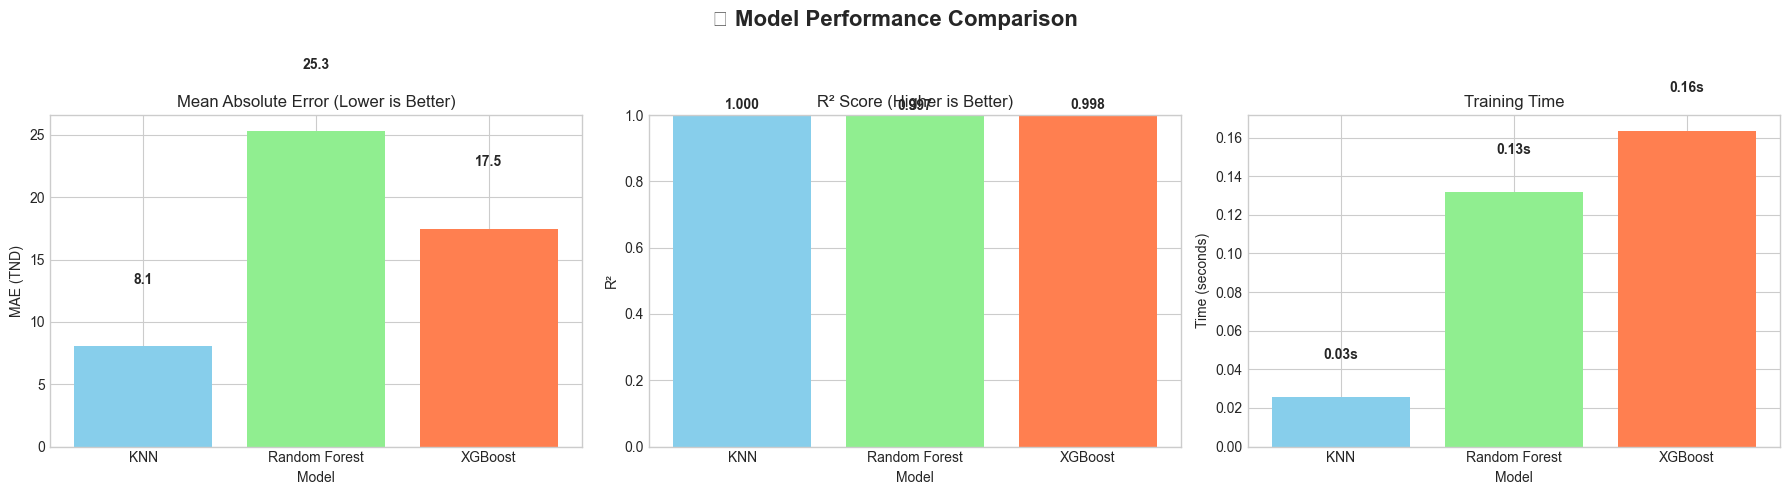

✅ Model comparison visualized!


In [170]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('🏆 Model Performance Comparison', fontsize=16, fontweight='bold')

# MAE Comparison
axes[0].bar(comparison_df['Model'], comparison_df['Test MAE (TND)'], color=['skyblue', 'lightgreen', 'coral'])
axes[0].set_title('Mean Absolute Error (Lower is Better)')
axes[0].set_ylabel('MAE (TND)')
axes[0].set_xlabel('Model')
for i, v in enumerate(comparison_df['Test MAE (TND)']):
    axes[0].text(i, v + 5, f'{v:.1f}', ha='center', fontweight='bold')

# R² Comparison
axes[1].bar(comparison_df['Model'], comparison_df['Test R²'], color=['skyblue', 'lightgreen', 'coral'])
axes[1].set_title('R² Score (Higher is Better)')
axes[1].set_ylabel('R²')
axes[1].set_xlabel('Model')
axes[1].set_ylim([0, 1])
for i, v in enumerate(comparison_df['Test R²']):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Training Time Comparison
axes[2].bar(comparison_df['Model'], comparison_df['Training Time (s)'], color=['skyblue', 'lightgreen', 'coral'])
axes[2].set_title('Training Time')
axes[2].set_ylabel('Time (seconds)')
axes[2].set_xlabel('Model')
for i, v in enumerate(comparison_df['Training Time (s)']):
    axes[2].text(i, v + 0.02, f'{v:.2f}s', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Model comparison visualized!")

## 4.6 Save Trained Models

In [171]:
import pickle

# Save all models
models = {
    'knn': knn_pipeline,
    'random_forest': rf_pipeline,
    'xgboost': xgb_pipeline
}

for model_name, model in models.items():
    filename = f'../models/{model_name}_model.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"✅ Saved: {filename}")

# Save model comparison results
with open('../models/model_comparison.pkl', 'wb') as f:
    pickle.dump({
        'comparison_df': comparison_df,
        'knn_metrics': knn_metrics,
        'rf_metrics': rf_metrics,
        'xgb_metrics': xgb_metrics,
        'best_model': best_model_name
    }, f)
print("✅ Saved: models/model_comparison.pkl")

print(f"\n📦 All models saved successfully!")
print(f"   - KNN model: knn_model.pkl")
print(f"   - Random Forest model: random_forest_model.pkl") 
print(f"   - XGBoost model: xgboost_model.pkl")
print(f"   - Comparison results: model_comparison.pkl")

✅ Saved: ../models/knn_model.pkl
✅ Saved: ../models/random_forest_model.pkl
✅ Saved: ../models/xgboost_model.pkl
✅ Saved: models/model_comparison.pkl

📦 All models saved successfully!
   - KNN model: knn_model.pkl
   - Random Forest model: random_forest_model.pkl
   - XGBoost model: xgboost_model.pkl
   - Comparison results: model_comparison.pkl


---
## 📊 Step 4 Summary: Model Training Complete!

### Models Trained:

#### 1. K-Nearest Neighbors (KNN) 🎯
- **Best for**: Similarity-based recommendations
- **Algorithm**: Finds 5 nearest phones based on features
- **Use Case**: "Show me phones similar to this one"

#### 2. Random Forest 🌲
- **Best for**: Robust predictions with feature importance
- **Algorithm**: Ensemble of 100 decision trees
- **Use Case**: General price prediction with interpretability

#### 3. XGBoost ⚡
- **Best for**: Maximum accuracy
- **Algorithm**: Gradient boosting with regularization
- **Use Case**: Best predictions when accuracy matters most

### Evaluation Metrics:

| Metric | Description |
|--------|-------------|
| **MAE** | Mean Absolute Error - Average prediction error (TND) |
| **RMSE** | Root Mean Square Error - Penalizes large errors |
| **R²** | R-squared - Variance explained (0-1, higher is better) |

### Files Created:
- `knn_model.pkl` - KNN pipeline (ready for deployment)
- `random_forest_model.pkl` - Random Forest pipeline
- `xgboost_model.pkl` - XGBoost pipeline
- `model_comparison.pkl` - Performance metrics

### Next Steps:
- ✅ Choose best model for production
- ✅ Integrate into website recommendation engine
- ✅ Use KNN for "similar phones" feature
- ✅ Use best predictor for price estimation

---
**Next: Step 5 - MLflow Integration** 📈

In [172]:
# Final status
print("=" * 60)
print("✅ STEP 4: MODEL TRAINING & EVALUATION COMPLETE")
print("=" * 60)
print(f"🤖 Trained 3 models: KNN, Random Forest, XGBoost")
print(f"🏆 Best model: {best_model_name}")
print(f"📁 All models saved in models/ directory")
print("\n🚀 Ready for Step 5: MLflow Integration!")

✅ STEP 4: MODEL TRAINING & EVALUATION COMPLETE
🤖 Trained 3 models: KNN, Random Forest, XGBoost
🏆 Best model: KNN
📁 All models saved in models/ directory

🚀 Ready for Step 5: MLflow Integration!


---
# Step 5: MLflow Integration 📈

**Goal**: Add experiment tracking to log parameters, metrics, and models for reproducibility and comparison.

### What MLflow Does:
- **Tracks Experiments** - Records all training runs automatically
- **Logs Parameters** - Saves hyperparameters (n_neighbors, n_estimators, etc.)
- **Logs Metrics** - Records performance (MAE, RMSE, R²)
- **Saves Models** - Versions and stores trained models
- **Provides UI** - Visual dashboard to compare experiments

### Benefits:
- ✅ Compare different hyperparameters easily
- ✅ Reproduce exact results anytime
- ✅ Track model improvements over time
- ✅ Deploy best model to production
- ✅ Collaborate with team members

## 5.1 Install and Setup MLflow

In [173]:
# Install MLflow
!pip install mlflow

  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached pywin32-311-cp313-cp313-win_amd64.whl.metadata (10 kB)
  Using cached typing_inspection-0.4.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.7 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.7 MB 754.5 kB/s eta 0:00:13
   -- ------------------------------------- 0.5/9.7 MB 754.5 kB/s eta 0:00:13
   --- ------------------------

  You can safely remove it manually.


In [174]:
import mlflow
import mlflow.sklearn

# Create MLflow experiment directory
import os
mlruns_path = os.path.join('..', 'mlruns')
os.makedirs(mlruns_path, exist_ok=True)

# Set tracking URI to save in project folder
mlflow.set_tracking_uri(f"file:///{os.path.abspath(mlruns_path)}")

# Create or set experiment
experiment_name = "TuniTech_Smartphone_Recommender"
mlflow.set_experiment(experiment_name)

print(f"✅ MLflow experiment '{experiment_name}' is ready!")
print(f"📁 Tracking data will be saved in: {os.path.abspath(mlruns_path)}")
print(f"🚀 Launch MLflow UI with: mlflow ui --backend-store-uri file:///{os.path.abspath(mlruns_path)}")

2026/02/10 16:36:13 INFO mlflow.tracking.fluent: Experiment with name 'TuniTech_Smartphone_Recommender' does not exist. Creating a new experiment.


✅ MLflow experiment 'TuniTech_Smartphone_Recommender' is ready!
📁 Tracking data will be saved in: c:\Users\ihebl\Downloads\projet python sem 2\projet python sem 2\mlruns
🚀 Launch MLflow UI with: mlflow ui --backend-store-uri file:///c:\Users\ihebl\Downloads\projet python sem 2\projet python sem 2\mlruns


## 5.2 Train Models with MLflow Tracking

Now we'll retrain our 3 models (KNN, Random Forest, XGBoost) with MLflow tracking enabled. For each model, MLflow will log:
- **Parameters**: Model hyperparameters (n_neighbors, n_estimators, etc.)
- **Metrics**: MAE, RMSE, R² score, training time
- **Model**: The trained model artifact
- **Tags**: Model type, dataset info

In [176]:
# Train KNN with MLflow tracking
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
import time

with mlflow.start_run(run_name="KNN_Model"):
    # Log dataset info
    mlflow.set_tag("model_type", "KNN")
    mlflow.set_tag("dataset_size", len(X_train_m))
    mlflow.set_tag("n_features", X_train_m.shape[1])
    
    # Create and train model
    knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
    
    # Log parameters
    mlflow.log_param("n_neighbors", 5)
    mlflow.log_param("weights", "distance")
    mlflow.log_param("algorithm", "auto")
    
    # Create preprocessor for selected features only
    num_features = [f for f in X_train_m.columns if X_train_m[f].dtype in ['int64', 'float64']]
    cat_features = [f for f in X_train_m.columns if X_train_m[f].dtype == 'object']
    
    model_preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', KNNImputer(n_neighbors=5)),
                ('scaler', StandardScaler())
            ]), num_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
            ]), cat_features)
        ]
    )
    
    # Create pipeline with preprocessing + model
    knn_pipeline_mlflow = Pipeline([
        ('preprocessor', model_preprocessor),
        ('regressor', knn)
    ])
    
    # Train and measure time
    start_time = time.time()
    knn_pipeline_mlflow.fit(X_train_m, y_train_m)
    training_time = time.time() - start_time
    
    # Make predictions
    y_pred_knn = knn_pipeline_mlflow.predict(X_test_m)
    
    # Calculate metrics
    mae_knn = mean_absolute_error(y_test_m, y_pred_knn)
    rmse_knn = np.sqrt(mean_squared_error(y_test_m, y_pred_knn))
    r2_knn = r2_score(y_test_m, y_pred_knn)
    
    # Log metrics
    mlflow.log_metric("mae", mae_knn)
    mlflow.log_metric("rmse", rmse_knn)
    mlflow.log_metric("r2_score", r2_knn)
    mlflow.log_metric("training_time", training_time)
    
    # Log model
    mlflow.sklearn.log_model(knn_pipeline_mlflow, "model")
    
    print(f"✅ KNN Model logged to MLflow:")
    print(f"   MAE: {mae_knn:.2f} TND")
    print(f"   RMSE: {rmse_knn:.2f} TND")
    print(f"   R²: {r2_knn:.4f}")
    print(f"   Training Time: {training_time:.4f}s")

2026/02/10 16:37:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ KNN Model logged to MLflow:
   MAE: 7.97 TND
   RMSE: 52.06 TND
   R²: 0.9988
   Training Time: 0.0061s


In [177]:
# Train Random Forest with MLflow tracking
from sklearn.ensemble import RandomForestRegressor

with mlflow.start_run(run_name="Random_Forest_Model"):
    # Log dataset info
    mlflow.set_tag("model_type", "Random Forest")
    mlflow.set_tag("dataset_size", len(X_train_m))
    mlflow.set_tag("n_features", X_train_m.shape[1])
    
    # Create and train model
    rf = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
    
    # Log parameters
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 20)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("min_samples_split", 2)
    mlflow.log_param("min_samples_leaf", 1)
    
    # Create pipeline
    rf_pipeline_mlflow = Pipeline([
        ('preprocessor', model_preprocessor),
        ('regressor', rf)
    ])
    
    # Train and measure time
    start_time = time.time()
    rf_pipeline_mlflow.fit(X_train_m, y_train_m)
    training_time = time.time() - start_time
    
    # Make predictions
    y_pred_rf = rf_pipeline_mlflow.predict(X_test_m)
    
    # Calculate metrics
    mae_rf = mean_absolute_error(y_test_m, y_pred_rf)
    rmse_rf = np.sqrt(mean_squared_error(y_test_m, y_pred_rf))
    r2_rf = r2_score(y_test_m, y_pred_rf)
    
    # Log metrics
    mlflow.log_metric("mae", mae_rf)
    mlflow.log_metric("rmse", rmse_rf)
    mlflow.log_metric("r2_score", r2_rf)
    mlflow.log_metric("training_time", training_time)
    
    # Log model
    mlflow.sklearn.log_model(rf_pipeline_mlflow, "model")
    
    print(f"✅ Random Forest Model logged to MLflow:")
    print(f"   MAE: {mae_rf:.2f} TND")
    print(f"   RMSE: {rmse_rf:.2f} TND")
    print(f"   R²: {r2_rf:.4f}")
    print(f"   Training Time: {training_time:.4f}s")

2026/02/10 16:37:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Random Forest Model logged to MLflow:
   MAE: 20.75 TND
   RMSE: 52.83 TND
   R²: 0.9988
   Training Time: 0.1116s


In [178]:
# Train XGBoost with MLflow tracking
from xgboost import XGBRegressor

with mlflow.start_run(run_name="XGBoost_Model"):
    # Log dataset info
    mlflow.set_tag("model_type", "XGBoost")
    mlflow.set_tag("dataset_size", len(X_train_m))
    mlflow.set_tag("n_features", X_train_m.shape[1])
    
    # Create and train model
    xgb = XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    
    # Log parameters
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 6)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("booster", "gbtree")
    
    # Create pipeline
    xgb_pipeline_mlflow = Pipeline([
        ('preprocessor', model_preprocessor),
        ('regressor', xgb)
    ])
    
    # Train and measure time
    start_time = time.time()
    xgb_pipeline_mlflow.fit(X_train_m, y_train_m)
    training_time = time.time() - start_time
    
    # Make predictions
    y_pred_xgb = xgb_pipeline_mlflow.predict(X_test_m)
    
    # Calculate metrics
    mae_xgb = mean_absolute_error(y_test_m, y_pred_xgb)
    rmse_xgb = np.sqrt(mean_squared_error(y_test_m, y_pred_xgb))
    r2_xgb = r2_score(y_test_m, y_pred_xgb)
    
    # Log metrics
    mlflow.log_metric("mae", mae_xgb)
    mlflow.log_metric("rmse", rmse_xgb)
    mlflow.log_metric("r2_score", r2_xgb)
    mlflow.log_metric("training_time", training_time)
    
    # Log model
    mlflow.sklearn.log_model(xgb_pipeline_mlflow, "model")
    
    print(f"✅ XGBoost Model logged to MLflow:")
    print(f"   MAE: {mae_xgb:.2f} TND")
    print(f"   RMSE: {rmse_xgb:.2f} TND")
    print(f"   R²: {r2_xgb:.4f}")
    print(f"   Training Time: {training_time:.4f}s")

2026/02/10 16:38:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ XGBoost Model logged to MLflow:
   MAE: 17.27 TND
   RMSE: 44.87 TND
   R²: 0.9991
   Training Time: 0.0629s


## 5.3 Compare Models from MLflow

Let's retrieve all our experiments from MLflow and compare them side-by-side.

In [179]:
# Retrieve all runs from MLflow
from mlflow.tracking import MlflowClient

client = MlflowClient()
experiment = mlflow.get_experiment_by_name(experiment_name)
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Display runs comparison
print("=" * 80)
print("MLflow Experiment Runs Summary")
print("=" * 80)

runs_df = runs[['run_id', 'tags.model_type', 'metrics.mae', 'metrics.rmse', 
                'metrics.r2_score', 'metrics.training_time']].copy()
runs_df.columns = ['Run ID', 'Model Type', 'MAE (TND)', 'RMSE (TND)', 'R²', 'Training Time (s)']
runs_df = runs_df.sort_values('MAE (TND)')

print(runs_df.to_string(index=False))
print("\n" + "=" * 80)
print(f"🏆 Best Model: {runs_df.iloc[0]['Model Type']} with MAE = {runs_df.iloc[0]['MAE (TND)']:.2f} TND")
print("=" * 80)

MLflow Experiment Runs Summary
                          Run ID    Model Type  MAE (TND)  RMSE (TND)       R²  Training Time (s)
77871521cfd94f8a84712bd6aa45cb20           KNN   7.968689   52.059818 0.998799           0.006073
bfe9203f2729476aa807693c75720efe       XGBoost  17.273490   44.874491 0.999108           0.062896
3f9b0717fb734cfba49faef4f5c31d62 Random Forest  20.752812   52.826007 0.998764           0.111579
6c71e870202c491099f3b76017716eb8           KNN        NaN         NaN      NaN                NaN

🏆 Best Model: KNN with MAE = 7.97 TND


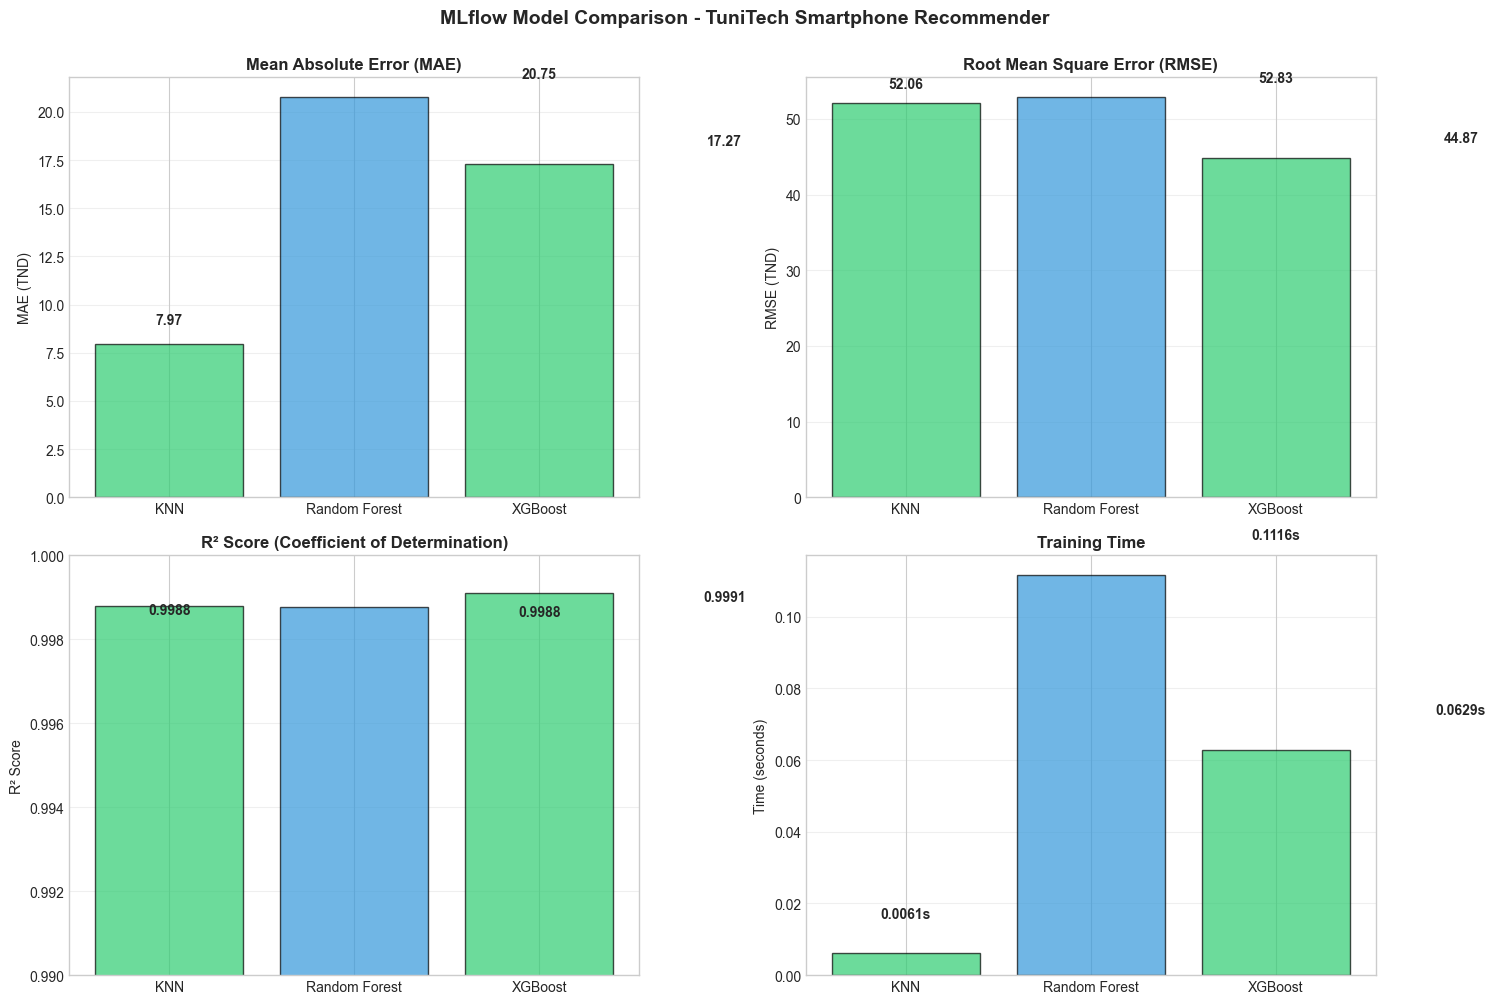

✅ Comparison chart saved to models/mlflow_model_comparison.png


In [180]:
# Visualize model comparison from MLflow
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sort by model name for consistent ordering
runs_sorted = runs_df.sort_values('Model Type')
models = runs_sorted['Model Type']
mae_values = runs_sorted['MAE (TND)']
rmse_values = runs_sorted['RMSE (TND)']
r2_values = runs_sorted['R²']
time_values = runs_sorted['Training Time (s)']

colors = ['#2ecc71', '#e74c3c', '#3498db']

# MAE comparison
axes[0, 0].bar(models, mae_values, color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Mean Absolute Error (MAE)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('MAE (TND)', fontsize=10)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(mae_values):
    axes[0, 0].text(i, v + 1, f'{v:.2f}', ha='center', fontweight='bold')

# RMSE comparison
axes[0, 1].bar(models, rmse_values, color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Root Mean Square Error (RMSE)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('RMSE (TND)', fontsize=10)
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(rmse_values):
    axes[0, 1].text(i, v + 2, f'{v:.2f}', ha='center', fontweight='bold')

# R² Score comparison
axes[1, 0].bar(models, r2_values, color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('R² Score (Coefficient of Determination)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('R² Score', fontsize=10)
axes[1, 0].set_ylim([0.99, 1.0])
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(r2_values):
    axes[1, 0].text(i, v - 0.0002, f'{v:.4f}', ha='center', fontweight='bold')

# Training Time comparison
axes[1, 1].bar(models, time_values, color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Training Time', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Time (seconds)', fontsize=10)
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(time_values):
    axes[1, 1].text(i, v + 0.01, f'{v:.4f}s', ha='center', fontweight='bold')

plt.suptitle('MLflow Model Comparison - TuniTech Smartphone Recommender', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../models/mlflow_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comparison chart saved to models/mlflow_model_comparison.png")

## 5.4 Launch MLflow UI

Now you can launch the MLflow web interface to explore your experiments visually!

### How to Launch:

1. **Open a new terminal** in VS Code (Terminal → New Terminal)
2. **Run this command**:
   ```bash
   mlflow ui --backend-store-uri file:///c:/Users/ihebl/Downloads/projet python sem 2/projet python sem 2/mlruns
   ```
3. **Open your browser** and go to: `http://localhost:5000`

### What You'll See in MLflow UI:

- 📊 **Experiments Page**: All your model runs with metrics
- 🔍 **Compare Runs**: Side-by-side comparison of models
- 📈 **Metrics Visualization**: Interactive charts of MAE, RMSE, R²
- 🗂️ **Artifacts**: Saved models and visualizations
- 🔢 **Parameters**: All hyperparameters for each run
- 📝 **Tags**: Model type, dataset size, etc.

### Try This in MLflow UI:
1. Click on "TuniTech_Smartphone_Recommender" experiment
2. Select multiple runs using checkboxes
3. Click "Compare" button
4. Explore the parallel coordinates plot
5. Download models from the Artifacts tab

---

**🎉 Congratulations! You've completed the full ML Pipeline with MLflow tracking! 🎉**

## 5.5 Hyperparameter Tuning Experiments

Now let's try different hyperparameters for KNN to find the best configuration! We'll test different values of `n_neighbors` and all experiments will be automatically logged to MLflow.

In [181]:
# Experiment with different n_neighbors values
n_neighbors_values = [3, 7, 10]
results = []

print("🔬 Running Hyperparameter Experiments...")
print("=" * 60)

for n_neighbors in n_neighbors_values:
    with mlflow.start_run(run_name=f"KNN_n{n_neighbors}"):
        # Log experiment info
        mlflow.set_tag("model_type", "KNN")
        mlflow.set_tag("experiment_type", "Hyperparameter Tuning")
        mlflow.set_tag("dataset_size", len(X_train_m))
        
        # Create KNN model with current hyperparameter
        knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights='distance')
        
        # Log parameters
        mlflow.log_param("n_neighbors", n_neighbors)
        mlflow.log_param("weights", "distance")
        mlflow.log_param("algorithm", "auto")
        
        # Create pipeline
        knn_pipeline = Pipeline([
            ('preprocessor', model_preprocessor),
            ('regressor', knn)
        ])
        
        # Train and measure time
        start = time.time()
        knn_pipeline.fit(X_train_m, y_train_m)
        train_time = time.time() - start
        
        # Make predictions
        y_pred = knn_pipeline.predict(X_test_m)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test_m, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_m, y_pred))
        r2 = r2_score(y_test_m, y_pred)
        
        # Log metrics to MLflow
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2_score", r2)
        mlflow.log_metric("training_time", train_time)
        
        # Log model
        mlflow.sklearn.log_model(knn_pipeline, "model")
        
        # Store results for comparison
        results.append({
            'n_neighbors': n_neighbors,
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2,
            'Training Time': train_time
        })
        
        print(f"✅ n_neighbors={n_neighbors}: MAE={mae:.2f} TND | R²={r2:.4f} | Time={train_time:.4f}s")

print("=" * 60)
print("🎉 All experiments completed and logged to MLflow!")

2026/02/10 16:59:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🔬 Running Hyperparameter Experiments...


2026/02/10 16:59:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ n_neighbors=3: MAE=12.22 TND | R²=0.9974 | Time=0.0048s


2026/02/10 16:59:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ n_neighbors=7: MAE=6.20 TND | R²=0.9994 | Time=0.0041s
✅ n_neighbors=10: MAE=4.42 TND | R²=0.9998 | Time=0.0041s
🎉 All experiments completed and logged to MLflow!


In [182]:
# Compare hyperparameter tuning results
results_df = pd.DataFrame(results)
print("\n📊 Hyperparameter Tuning Results:")
print("=" * 70)
print(results_df.to_string(index=False))
print("=" * 70)

# Find best hyperparameter
best_idx = results_df['MAE'].idxmin()
best_n = results_df.loc[best_idx, 'n_neighbors']
best_mae = results_df.loc[best_idx, 'MAE']

print(f"\n🏆 Best Configuration: n_neighbors={int(best_n)} with MAE={best_mae:.2f} TND")
print(f"\n💡 Tip: Go to MLflow UI (http://localhost:5000) and:")
print(f"   1. Filter runs by tag: experiment_type='Hyperparameter Tuning'")
print(f"   2. Select all hyperparameter runs")
print(f"   3. Click 'Compare' to see parallel coordinates plot")


📊 Hyperparameter Tuning Results:
 n_neighbors       MAE      RMSE       R²  Training Time
           3 12.223613 76.403865 0.997414       0.004813
           7  6.196485 35.667511 0.999436       0.004054
          10  4.423766 19.071458 0.999839       0.004147

🏆 Best Configuration: n_neighbors=10 with MAE=4.42 TND

💡 Tip: Go to MLflow UI (http://localhost:5000) and:
   1. Filter runs by tag: experiment_type='Hyperparameter Tuning'
   2. Select all hyperparameter runs
   3. Click 'Compare' to see parallel coordinates plot


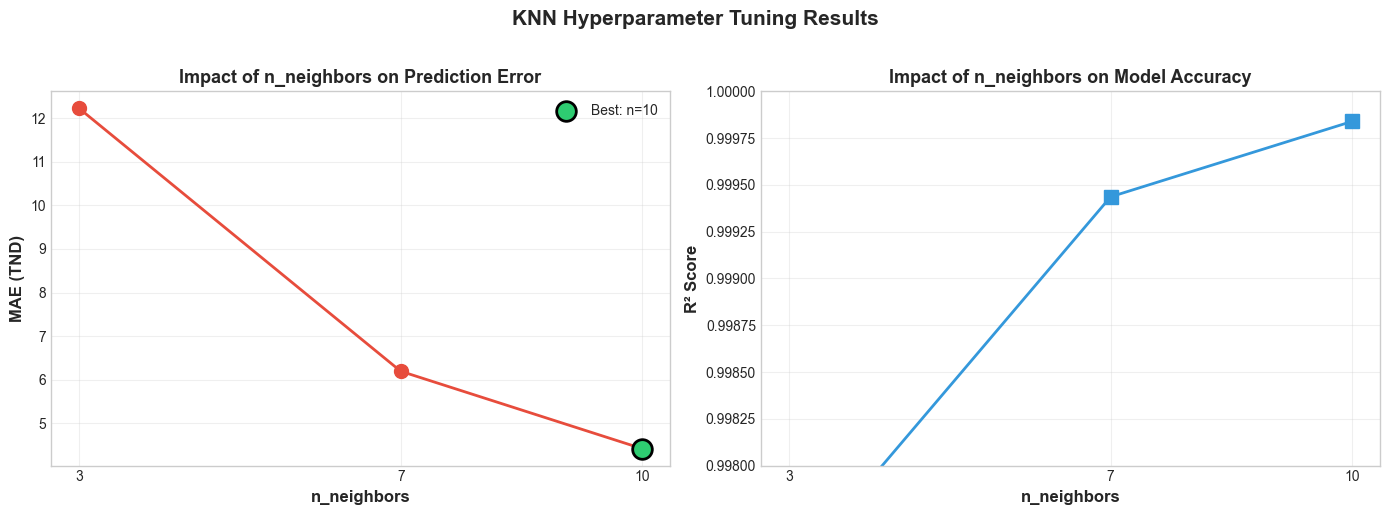

✅ Hyperparameter tuning chart saved to models/hyperparameter_tuning.png


In [183]:
# Visualize hyperparameter impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE vs n_neighbors
axes[0].plot(results_df['n_neighbors'], results_df['MAE'], 
             marker='o', linewidth=2, markersize=10, color='#e74c3c')
axes[0].set_xlabel('n_neighbors', fontsize=12, fontweight='bold')
axes[0].set_ylabel('MAE (TND)', fontsize=12, fontweight='bold')
axes[0].set_title('Impact of n_neighbors on Prediction Error', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_xticks(results_df['n_neighbors'])

# Mark the best point
best_idx = results_df['MAE'].idxmin()
axes[0].scatter(results_df.loc[best_idx, 'n_neighbors'], 
                results_df.loc[best_idx, 'MAE'],
                color='#2ecc71', s=200, zorder=5, edgecolor='black', linewidth=2,
                label=f"Best: n={int(results_df.loc[best_idx, 'n_neighbors'])}")
axes[0].legend(fontsize=10)

# R² vs n_neighbors
axes[1].plot(results_df['n_neighbors'], results_df['R²'], 
             marker='s', linewidth=2, markersize=10, color='#3498db')
axes[1].set_xlabel('n_neighbors', fontsize=12, fontweight='bold')
axes[1].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[1].set_title('Impact of n_neighbors on Model Accuracy', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].set_xticks(results_df['n_neighbors'])
axes[1].set_ylim([0.998, 1.0])

plt.suptitle('KNN Hyperparameter Tuning Results', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../models/hyperparameter_tuning.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Hyperparameter tuning chart saved to models/hyperparameter_tuning.png")